In [1]:
# Import all necessary libraries and the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
import sys
import warnings
warnings.filterwarnings('ignore')
from nba_analysis_functions import *
%matplotlib inline

df = pd.read_csv('nba_team_stats_01_to_24.csv')
df.head()

,teamstatspk,Team,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
0,0,Boston Celtics,82,64,18,0.780,3966,9887,3601,7396,...,3799,2207,979,557,538,304,1326,1416,930,2023-24
1,1,Denver Nuggets,82,57,25,0.695,3941,9418,3610,7279,...,3643,2415,1036,585,456,394,1489,1467,431,2023-24
2,2,Oklahoma City Thunder,82,57,25,0.695,3961,9847,3653,7324,...,3447,2223,1039,694,538,419,1545,1548,608,2023-24
3,3,Minnesota Timberwolves,82,56,26,0.683,3961,9264,3383,6974,...,3577,2184,1162,647,497,371,1544,1630,529,2023-24
4,4,LA Clippers,82,51,31,0.622,3941,9481,3473,7108,...,3523,2097,1078,640,413,384,1519,1537,269,2023-24


In [2]:
# Drop teamstatspk column
df.drop('teamstatspk', axis=1, inplace=True)

In [3]:
# Modify the season column to be the last 2 digits of the season year
df['season'] = df['season'].str[-2:].astype(int)

In [4]:
# Visually inspect the data for anomolies
df.describe()

,games_played,wins,losses,win_percentage,Min,points,field_goals_made,field_goals_attempted,field_goal_percentage,three_pointers_made,...,rebounds,assists,turnovers,steals,blocks,blocks_attempted,personal_fouls,personal_fouls_drawn,plus_minus,season
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,...,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.00000,716.000000,716.000000
mean,80.430168,40.215084,40.215084,0.499784,3888.927374,8230.385475,3062.220670,6716.244413,45.573743,654.132682,...,3439.062849,1812.224860,1155.023743,609.410615,393.428771,393.428771,1668.815642,1303.78352,0.000000,12.555866
std,4.286506,12.215024,12.133228,0.148919,207.684720,712.154467,251.252302,446.747528,1.686295,244.858190,...,232.258935,209.520421,111.140487,73.742012,67.002488,59.046211,175.680398,674.01655,366.105682,6.905229
min,64.000000,7.000000,9.000000,0.106000,3112.000000,5739.000000,2193.000000,5086.000000,40.800000,214.000000,...,2560.000000,1224.000000,738.000000,390.000000,195.000000,245.000000,1109.000000,0.00000,-918.000000,1.000000
25%,82.000000,32.000000,31.000000,0.390000,3951.000000,7838.500000,2931.750000,6490.750000,44.400000,466.000000,...,3325.000000,1680.000000,1086.000000,559.750000,345.000000,352.750000,1562.500000,1331.75000,-248.000000,7.000000
50%,82.000000,41.000000,39.000000,0.512000,3961.000000,8182.500000,3050.500000,6724.000000,45.500000,606.000000,...,3459.500000,1795.500000,1157.000000,605.000000,388.000000,392.500000,1676.000000,1604.00000,19.000000,13.000000
75%,82.000000,49.000000,49.000000,0.610000,3971.000000,8641.500000,3208.500000,7018.000000,46.700000,845.500000,...,3585.250000,1933.500000,1224.000000,657.000000,439.250000,431.000000,1786.000000,1708.00000,266.000000,19.000000
max,82.000000,73.000000,72.000000,0.890000,4016.000000,10110.000000,3855.000000,7739.000000,50.700000,1363.000000,...,4078.000000,2522.000000,1514.000000,844.000000,624.000000,565.000000,2189.000000,2104.00000,954.000000,24.000000


In [5]:
# Ensure there is no missing data and that all columns are of the correct data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Team                      716 non-null    object 
 1   games_played              716 non-null    int64  
 2   wins                      716 non-null    int64  
 3   losses                    716 non-null    int64  
 4   win_percentage            716 non-null    float64
 5   Min                       716 non-null    int64  
 6   points                    716 non-null    int64  
 7   field_goals_made          716 non-null    int64  
 8   field_goals_attempted     716 non-null    int64  
 9   field_goal_percentage     716 non-null    float64
 10  three_pointers_made       716 non-null    int64  
 11  three_pointers_attempted  716 non-null    int64  
 12  three_point_percentage    716 non-null    float64
 13  free_throws_made          716 non-null    int64  
 14  free_throw

In [6]:
# Create a copy of the dataframe that will only contain numerical data
df_num = df.copy()

In [7]:
# Drop the only non-numeric data type from the dataframe as well as features that will not be used for analysis
df_num.drop(['Team', 'games_played', 'wins', 'losses', 'Min'], axis=1, inplace=True)

In [8]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716 entries, 0 to 715
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            716 non-null    float64
 1   points                    716 non-null    int64  
 2   field_goals_made          716 non-null    int64  
 3   field_goals_attempted     716 non-null    int64  
 4   field_goal_percentage     716 non-null    float64
 5   three_pointers_made       716 non-null    int64  
 6   three_pointers_attempted  716 non-null    int64  
 7   three_point_percentage    716 non-null    float64
 8   free_throws_made          716 non-null    int64  
 9   free_throw_attempted      716 non-null    int64  
 10  free_throw_percentage     716 non-null    float64
 11  offensive_rebounds        716 non-null    int64  
 12  defensive_rebounds        716 non-null    int64  
 13  rebounds                  716 non-null    int64  
 14  assists   

In [9]:
# Create a new DataFrame containing only data from the 01-12 seasons
df_era1 = df_num[df_num['season'] < 13]

df_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            356 non-null    float64
 1   points                    356 non-null    int64  
 2   field_goals_made          356 non-null    int64  
 3   field_goals_attempted     356 non-null    int64  
 4   field_goal_percentage     356 non-null    float64
 5   three_pointers_made       356 non-null    int64  
 6   three_pointers_attempted  356 non-null    int64  
 7   three_point_percentage    356 non-null    float64
 8   free_throws_made          356 non-null    int64  
 9   free_throw_attempted      356 non-null    int64  
 10  free_throw_percentage     356 non-null    float64
 11  offensive_rebounds        356 non-null    int64  
 12  defensive_rebounds        356 non-null    int64  
 13  rebounds                  356 non-null    int64  
 14  assists      

In [10]:
df_era1['points'].describe()

count     356.000000
mean     7852.896067
std       595.445770
min      5739.000000
25%      7640.250000
50%      7936.000000
75%      8196.250000
max      9105.000000
Name: points, dtype: float64

In [11]:
df_era1['field_goals_made'].describe()

count     356.000000
mean     2935.617978
std       214.335475
min      2193.000000
25%      2851.000000
50%      2962.000000
75%      3056.500000
max      3430.000000
Name: field_goals_made, dtype: float64

In [12]:
df_era1['field_goals_attempted'].describe()

count     356.000000
mean     6506.769663
std       407.482775
min      5086.000000
25%      6410.250000
50%      6579.500000
75%      6738.500000
max      7406.000000
Name: field_goals_attempted, dtype: float64

In [13]:
df_era1['field_goal_percentage'].describe()

count    356.000000
mean      45.110955
std        1.580219
min       40.900000
25%       44.100000
50%       45.100000
75%       46.100000
max       50.400000
Name: field_goal_percentage, dtype: float64

In [14]:
# Convert field_goal_percentage to a decimal
df_era1['field_goal_percentage'] = df_era1['field_goal_percentage'] * .01

df_era1['field_goal_percentage'].describe()

count    356.000000
mean       0.451110
std        0.015802
min        0.409000
25%        0.441000
50%        0.451000
75%        0.461000
max        0.504000
Name: field_goal_percentage, dtype: float64

In [15]:
df_era1['three_pointers_made'].describe()

count    356.000000
mean     472.230337
std      125.620007
min      214.000000
25%      380.500000
50%      473.500000
75%      547.250000
max      841.000000
Name: three_pointers_made, dtype: float64

In [16]:
df_era1['three_pointers_attempted'].describe()

count     356.000000
mean     1326.589888
std       312.351283
min       641.000000
25%      1099.000000
50%      1315.000000
75%      1513.000000
max      2284.000000
Name: three_pointers_attempted, dtype: float64

In [17]:
df_era1['three_point_percentage'].describe()

count    356.000000
mean      35.376404
std        2.059797
min       27.800000
25%       34.200000
50%       35.300000
75%       36.700000
max       41.200000
Name: three_point_percentage, dtype: float64

In [18]:
# Convert three_point_percentage to a decimal
df_era1['three_point_percentage'] = df_era1['three_point_percentage'] * .01

df_era1['three_point_percentage'].describe()

count    356.000000
mean       0.353764
std        0.020598
min        0.278000
25%        0.342000
50%        0.353000
75%        0.367000
max        0.412000
Name: three_point_percentage, dtype: float64

In [19]:
df_era1['free_throws_made'].describe()

count     356.000000
mean     1509.429775
std       187.939226
min       889.000000
25%      1412.750000
50%      1520.000000
75%      1631.000000
max      1977.000000
Name: free_throws_made, dtype: float64

In [20]:
df_era1['free_throw_attempted'].describe()

count     356.000000
mean     1998.337079
std       247.296478
min      1198.000000
25%      1873.250000
50%      2009.000000
75%      2158.250000
max      2587.000000
Name: free_throw_attempted, dtype: float64

In [21]:
df_era1['free_throw_percentage'].describe()

count    356.000000
mean      75.580056
std        2.838373
min       66.000000
25%       73.900000
50%       75.750000
75%       77.225000
max       82.900000
Name: free_throw_percentage, dtype: float64

In [22]:
# Convert free_throw_percentage to a decimal
df_era1['free_throw_percentage'] = df_era1['free_throw_percentage'] * .01

df_era1['free_throw_percentage'].describe()

count    356.000000
mean       0.755801
std        0.028384
min        0.660000
25%        0.739000
50%        0.757500
75%        0.772250
max        0.829000
Name: free_throw_percentage, dtype: float64

In [23]:
df_era1['offensive_rebounds'].describe()

count     356.000000
mean      928.182584
std       113.022634
min       509.000000
25%       851.750000
50%       928.500000
75%      1002.250000
max      1345.000000
Name: offensive_rebounds, dtype: float64

In [24]:
df_era1['defensive_rebounds'].describe()

count     356.000000
mean     2443.508427
std       165.725014
min      1879.000000
25%      2376.000000
50%      2459.500000
75%      2550.000000
max      2751.000000
Name: defensive_rebounds, dtype: float64

In [25]:
df_era1['rebounds'].describe()

count     356.000000
mean     3371.691011
std       221.686684
min      2560.000000
25%      3296.750000
50%      3414.500000
75%      3507.000000
max      3830.000000
Name: rebounds, dtype: float64

In [26]:
df_era1['assists'].describe()

count     356.000000
mean     1721.674157
std       174.191300
min      1224.000000
25%      1628.250000
50%      1720.000000
75%      1826.250000
max      2188.000000
Name: assists, dtype: float64

In [27]:
df_era1['turnovers'].describe()

count     356.000000
mean     1173.502809
std       114.723120
min       738.000000
25%      1111.500000
50%      1183.500000
75%      1246.500000
max      1514.000000
Name: turnovers, dtype: float64

In [28]:
df_era1['steals'].describe()

count    356.000000
mean     605.536517
std       75.575250
min      390.000000
25%      556.000000
50%      599.000000
75%      654.000000
max      844.000000
Name: steals, dtype: float64

In [29]:
df_era1['blocks'].describe()

count    356.000000
mean     396.620787
std       70.164591
min      204.000000
25%      346.750000
50%      392.000000
75%      446.000000
max      576.000000
Name: blocks, dtype: float64

In [30]:
df_era1['blocks_attempted'].describe()

count    356.000000
mean     396.620787
std       58.192294
min      246.000000
25%      356.000000
50%      399.000000
75%      435.250000
max      560.000000
Name: blocks_attempted, dtype: float64

In [31]:
df_era1['personal_fouls'].describe()

count     356.000000
mean     1733.651685
std       183.988447
min      1109.000000
25%      1653.750000
50%      1748.500000
75%      1858.250000
max      2189.000000
Name: personal_fouls, dtype: float64

In [32]:
df_era1['personal_fouls_drawn'].describe()

count     356.000000
mean      999.497191
std       844.175879
min         0.000000
25%         6.000000
50%      1509.500000
75%      1746.250000
max      2104.000000
Name: personal_fouls_drawn, dtype: float64

In [33]:
# Upon inspection of the dataset, there are 147 rows that contain less than 20 fouls drawn. This indicates incomplete data, so drop the feature
df_era1 = df_era1.drop(['personal_fouls_drawn'], axis=1)

df_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            356 non-null    float64
 1   points                    356 non-null    int64  
 2   field_goals_made          356 non-null    int64  
 3   field_goals_attempted     356 non-null    int64  
 4   field_goal_percentage     356 non-null    float64
 5   three_pointers_made       356 non-null    int64  
 6   three_pointers_attempted  356 non-null    int64  
 7   three_point_percentage    356 non-null    float64
 8   free_throws_made          356 non-null    int64  
 9   free_throw_attempted      356 non-null    int64  
 10  free_throw_percentage     356 non-null    float64
 11  offensive_rebounds        356 non-null    int64  
 12  defensive_rebounds        356 non-null    int64  
 13  rebounds                  356 non-null    int64  
 14  assists      

In [34]:
# Calculate advanced statistics

In [35]:
# Calculate assist to turnover ratio
df_era1['ast_to_ratio'] = df_era1['assists'] / df_era1['turnovers']

# Calculate the total points from free throws
df_era1['points_from_free_throws'] = df_era1['free_throws_made']

# Calculate the percentage of points from free throws
df_era1['pct_pts_fts'] = (df_era1['points_from_free_throws'] / df_era1['points'])

# Calculate the assist to field goal ratio
df_era1['ast_fg_ratio'] = df_era1['assists'] / df_era1['field_goals_made']

# Calculate the effective field goal percentage
df_era1['eFG%'] = (df_era1['field_goals_made'] + 0.5 * df_era1['three_pointers_made']) / df_era1['field_goals_attempted']

In [36]:
# Inspect the advanced statistics

In [37]:
df_era1['ast_to_ratio'].describe()

count    356.000000
mean       1.477720
std        0.182787
min        1.013112
25%        1.341769
50%        1.465267
75%        1.590646
max        2.117078
Name: ast_to_ratio, dtype: float64

In [38]:
df_era1['points_from_free_throws'].describe()

count     356.000000
mean     1509.429775
std       187.939226
min       889.000000
25%      1412.750000
50%      1520.000000
75%      1631.000000
max      1977.000000
Name: points_from_free_throws, dtype: float64

In [39]:
df_era1['pct_pts_fts'].describe()

count    356.000000
mean       0.192021
std        0.017625
min        0.133806
25%        0.181230
50%        0.190503
75%        0.205303
max        0.239480
Name: pct_pts_fts, dtype: float64

In [40]:
df_era1['ast_fg_ratio'].describe()

count    356.000000
mean       0.586455
std        0.040953
min        0.478747
25%        0.558134
50%        0.584276
75%        0.611393
max        0.726676
Name: ast_fg_ratio, dtype: float64

In [41]:
df_era1['eFG%'].describe()

count    356.000000
mean       0.487412
std        0.020458
min        0.428408
25%        0.473378
50%        0.486786
75%        0.500196
max        0.551495
Name: eFG%, dtype: float64

In [42]:
df_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            356 non-null    float64
 1   points                    356 non-null    int64  
 2   field_goals_made          356 non-null    int64  
 3   field_goals_attempted     356 non-null    int64  
 4   field_goal_percentage     356 non-null    float64
 5   three_pointers_made       356 non-null    int64  
 6   three_pointers_attempted  356 non-null    int64  
 7   three_point_percentage    356 non-null    float64
 8   free_throws_made          356 non-null    int64  
 9   free_throw_attempted      356 non-null    int64  
 10  free_throw_percentage     356 non-null    float64
 11  offensive_rebounds        356 non-null    int64  
 12  defensive_rebounds        356 non-null    int64  
 13  rebounds                  356 non-null    int64  
 14  assists      

In [43]:
# Drop the plus_minus and season features
df_era1 = df_era1.drop(['plus_minus', 'season'], axis=1)

df_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   win_percentage            356 non-null    float64
 1   points                    356 non-null    int64  
 2   field_goals_made          356 non-null    int64  
 3   field_goals_attempted     356 non-null    int64  
 4   field_goal_percentage     356 non-null    float64
 5   three_pointers_made       356 non-null    int64  
 6   three_pointers_attempted  356 non-null    int64  
 7   three_point_percentage    356 non-null    float64
 8   free_throws_made          356 non-null    int64  
 9   free_throw_attempted      356 non-null    int64  
 10  free_throw_percentage     356 non-null    float64
 11  offensive_rebounds        356 non-null    int64  
 12  defensive_rebounds        356 non-null    int64  
 13  rebounds                  356 non-null    int64  
 14  assists      

In [44]:
# Create a DataFrame of the data without the target variable
era1_features = df_era1.drop(['win_percentage'], axis=1)

era1_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   points                    356 non-null    int64  
 1   field_goals_made          356 non-null    int64  
 2   field_goals_attempted     356 non-null    int64  
 3   field_goal_percentage     356 non-null    float64
 4   three_pointers_made       356 non-null    int64  
 5   three_pointers_attempted  356 non-null    int64  
 6   three_point_percentage    356 non-null    float64
 7   free_throws_made          356 non-null    int64  
 8   free_throw_attempted      356 non-null    int64  
 9   free_throw_percentage     356 non-null    float64
 10  offensive_rebounds        356 non-null    int64  
 11  defensive_rebounds        356 non-null    int64  
 12  rebounds                  356 non-null    int64  
 13  assists                   356 non-null    int64  
 14  turnovers    

In [45]:
# Generate the matrix for the base features from era 1 minus the target feature with the gen_corr_matrix function
era1_matrix, era1_strong_correlations = gen_corr_matrix(era1_features)
era1_strong_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 1 to 501
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     12 non-null     object 
 1   Feature2     12 non-null     object 
 2   Correlation  12 non-null     float64
dtypes: float64(1), object(2)
memory usage: 384.0+ bytes


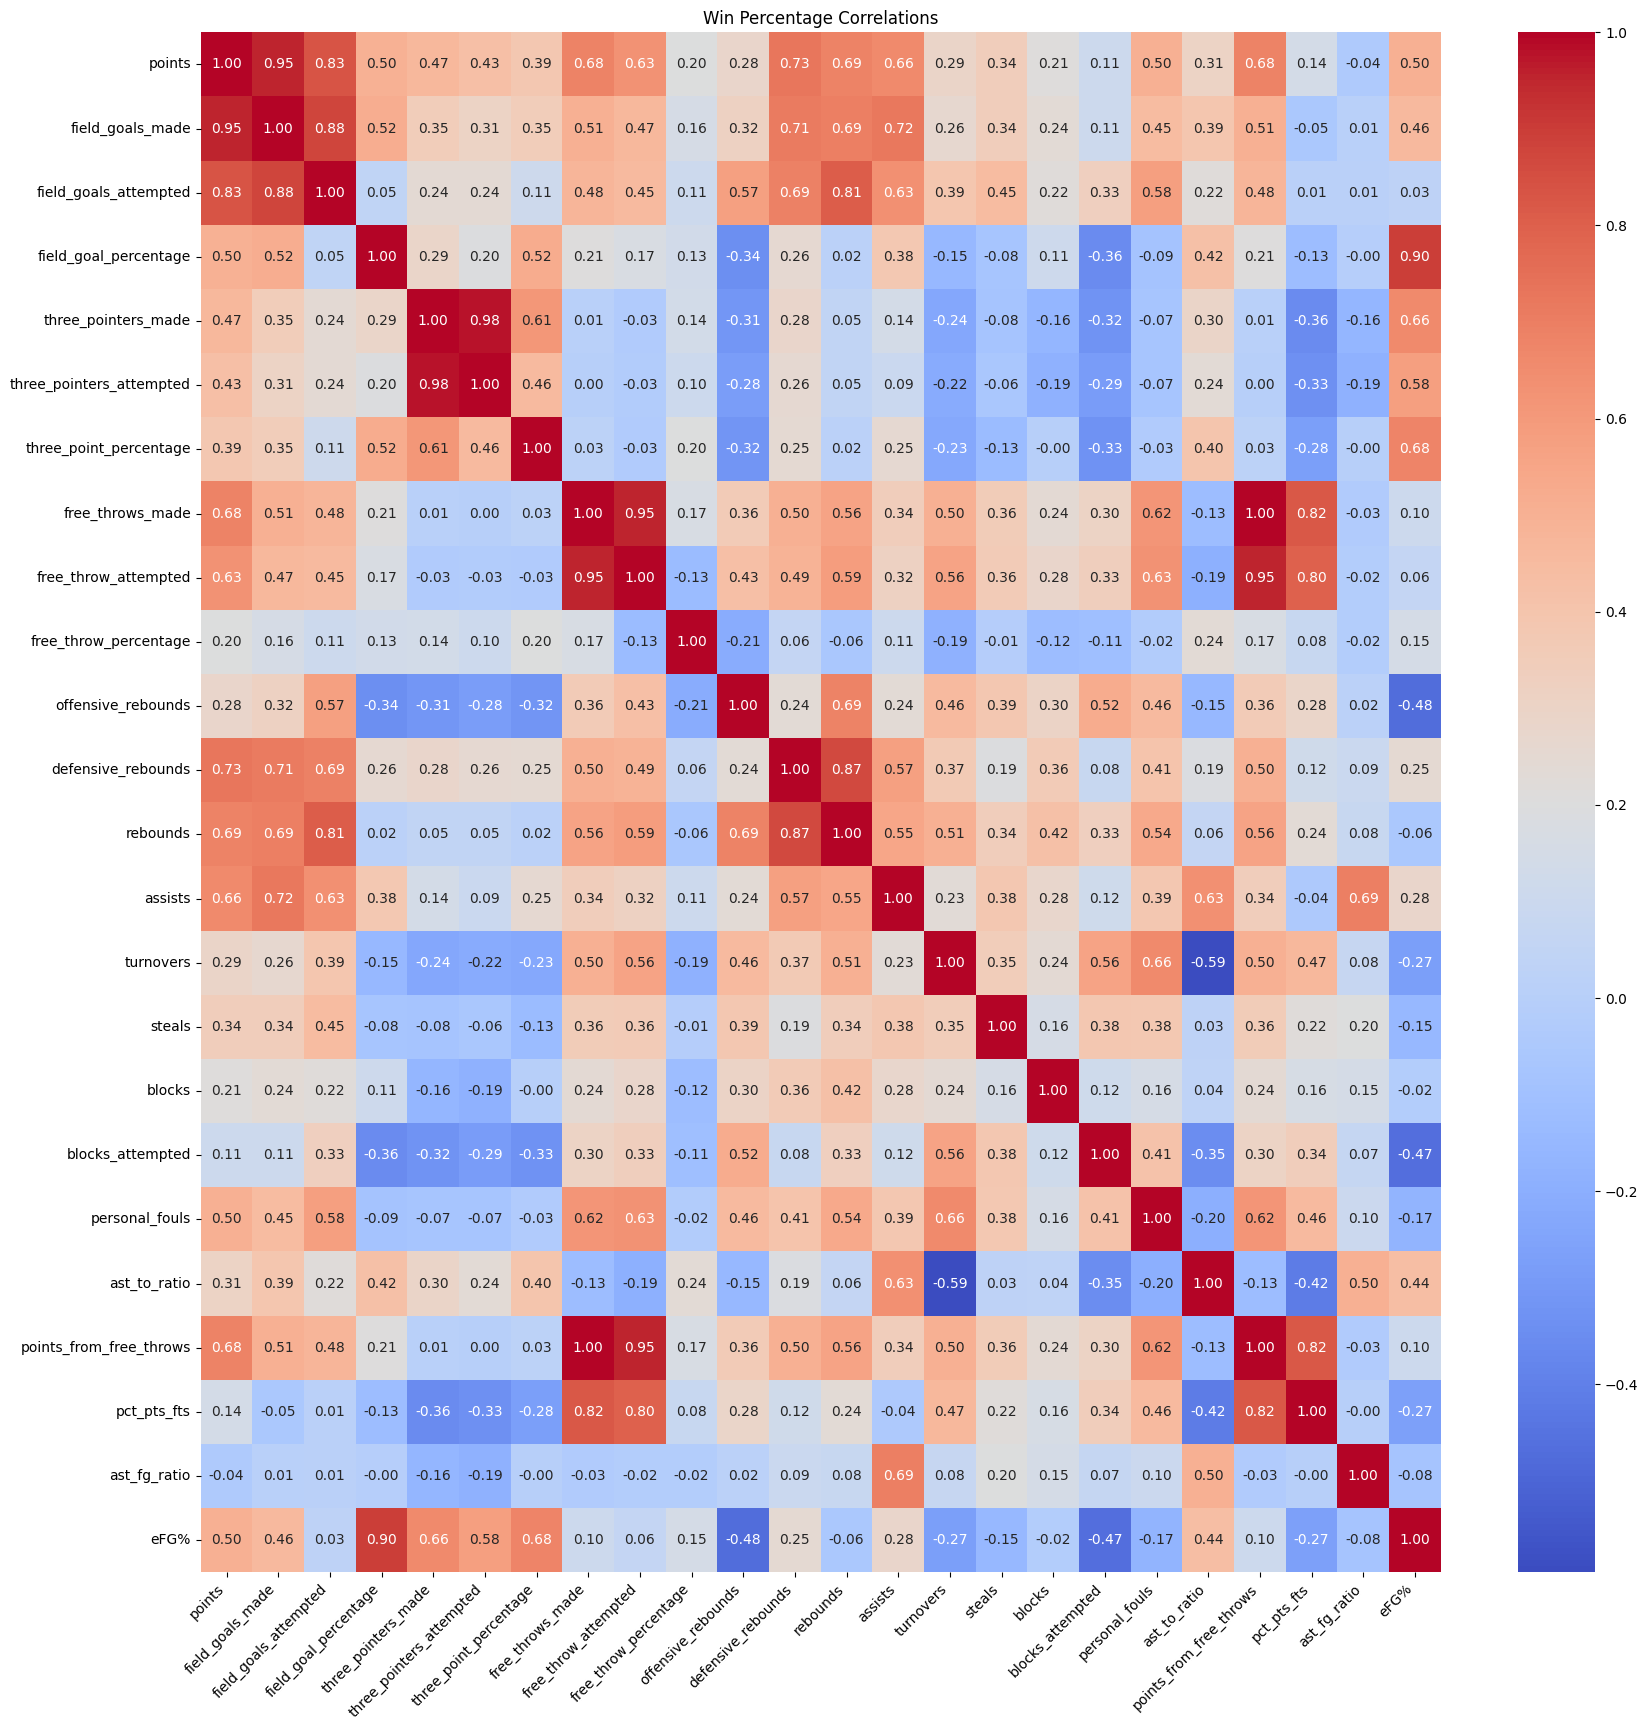

In [46]:
# Call the show_matrix function to display the correlation matrix
show_matrix(era1_matrix, 'Win Percentage')

In [47]:
# Display the strong correlations from the matrix of the entire dataset minus the target variable
print(era1_strong_correlations)

                    Feature1                  Feature2  Correlation
1                     points          field_goals_made     0.953595
2                     points     field_goals_attempted     0.834064
26          field_goals_made     field_goals_attempted     0.877199
60     field_goals_attempted                  rebounds     0.807004
95     field_goal_percentage                      eFG%     0.898854
101      three_pointers_made  three_pointers_attempted     0.981237
176         free_throws_made      free_throw_attempted     0.953456
188         free_throws_made   points_from_free_throws     1.000000
189         free_throws_made               pct_pts_fts     0.819672
212     free_throw_attempted   points_from_free_throws     0.953456
276       defensive_rebounds                  rebounds     0.868772
501  points_from_free_throws               pct_pts_fts     0.819672


In [48]:
# Call the drop_redundant_feats function on the dataset
era1_features = drop_redundant_feats(era1_strong_correlations, era1_features)

era1_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   assists                   356 non-null    int64  
 6   turnovers                 356 non-null    int64  
 7   steals                    356 non-null    int64  
 8   blocks                    356 non-null    int64  
 9   blocks_attempted          356 non-null    int64  
 10  personal_fouls            356 non-null    int64  
 11  ast_to_ratio              356 non-null    float64
 12  pct_pts_fts               356 non-null    float64
 13  ast_fg_ratio              356 non-null    float64
 14  eFG%         

In [49]:
# Drop the assists and turnovers features, as these can be accounted for in other features
era1_features = era1_features.drop(['assists', 'turnovers'], axis=1)

era1_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [50]:
# Create a copy of the dataset for later use
era1_feats_master = era1_features.copy()

In [51]:
# Define the target variable for the dataset
y = df_era1['win_percentage']

# Train the model for the dataset
results_era1, era1_features = gen_lasso_model(era1_features, y)

Best Alpha: 0.0001
Y Measurables: 
count    356.000000
mean       0.499997
std        0.149905
min        0.106000
25%        0.390000
50%        0.512000
75%        0.610000
max        0.817000
Name: win_percentage, dtype: float64
Training RMSE: 0.08665779601873354, Testing RMSE: 0.1036256681881577
Training R^2: 0.6611624696075225, Testing R^2: 0.5355111116603135
Non-zero Coefficients: 
eFG%                        0.061938
pct_pts_fts                 0.041808
rebounds                    0.037571
ast_to_ratio                0.037506
steals                      0.031182
three_point_percentage      0.019462
blocks                      0.011175
ast_fg_ratio                0.009867
offensive_rebounds         -0.000828
free_throw_percentage      -0.006951
three_pointers_attempted   -0.007814
blocks_attempted           -0.035918
personal_fouls             -0.052629
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.904549
1     

In [52]:
# With feature selection finalized, create a series of regression coefficients
era1_coefficients = pd.Series(results_era1['non_zero_coefficients'])

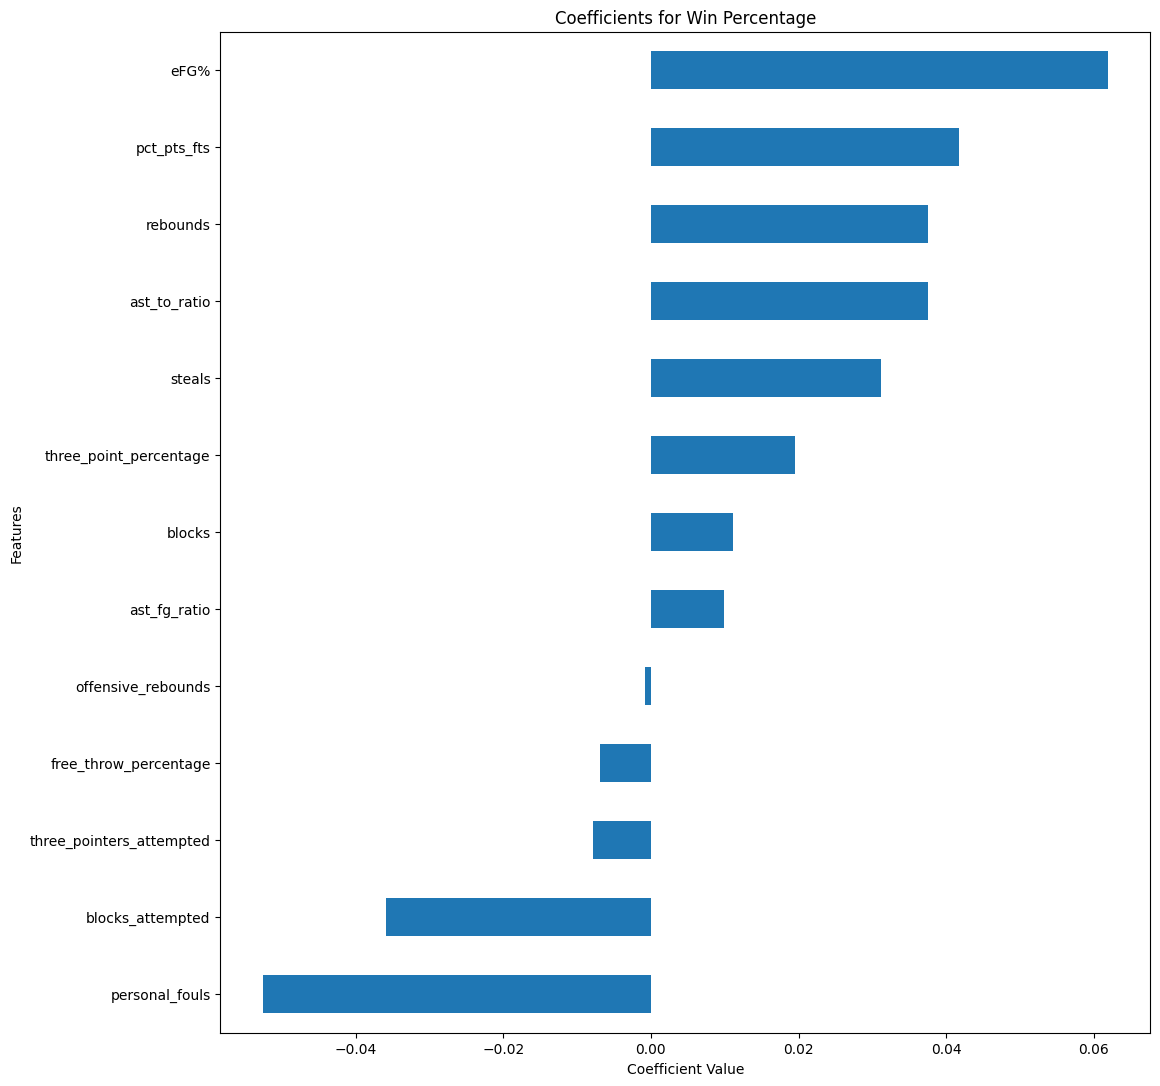

In [53]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(era1_coefficients, 'Win Percentage')

In [54]:
# Generate bootstrap coefficients 
bootstrap_results_era1 = gen_bootstrap_coefficients(
    results_era1['model'], results_era1['X'], results_era1['y'], results_era1['feature_names']
)

Average Y: 0.499997191011236
Average Training RMSE: 0.08752769027269675, Average Testing RMSE: 0.09167867216077263
Average Training R^2: 0.6551184549354541, Average Testing R^2: 0.612715573142651
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
eFG%                      0.051388  0.009682  0.032852  0.070859
rebounds                  0.044590  0.009586  0.025728  0.062459
pct_pts_fts               0.044358  0.007701  0.029435  0.059793
ast_to_ratio              0.036182  0.009591  0.017451  0.054013
steals                    0.034775  0.006485  0.022002  0.047143
three_point_percentage    0.022032  0.007869  0.006140  0.037036
blocks                    0.013313  0.006297  0.001202  0.026067
ast_fg_ratio              0.009078  0.007683 -0.005055  0.024762
offensive_rebounds       -0.007693  0.010747 -0.028056  0.013755
free_throw_percentage    -0.008186  0.005902 -0.019918  0.003296
three_pointers_attempted -0.008321  0.006845 -0.020891  0.005515
bl

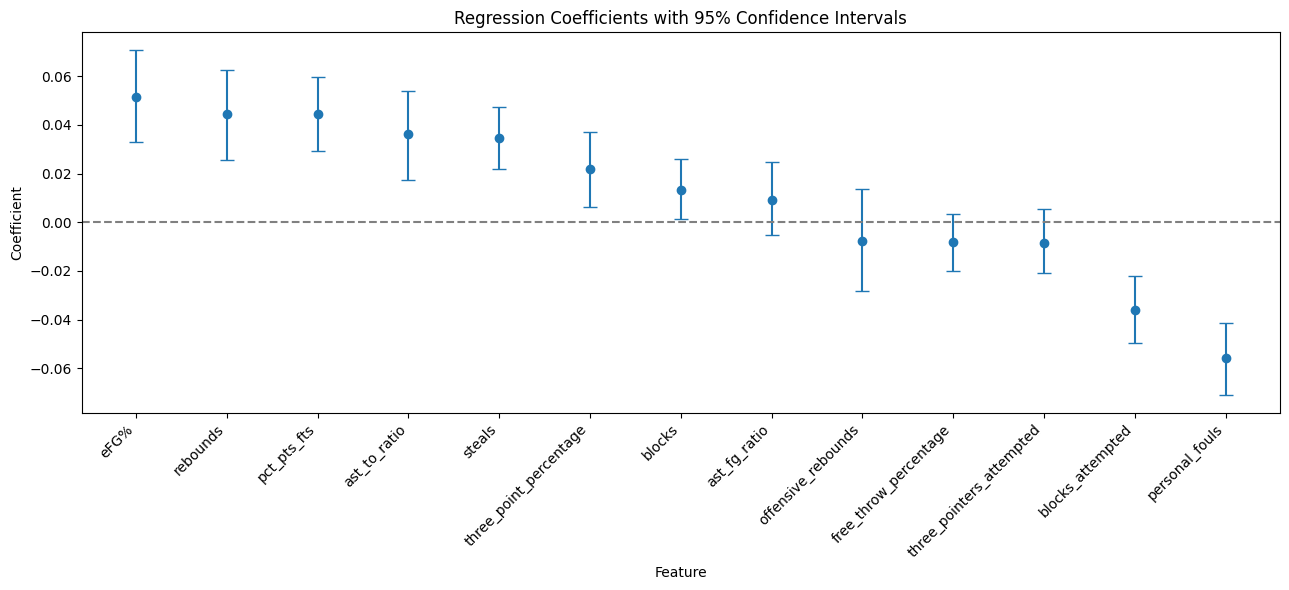

In [55]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_era1)

In [56]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_era1, era1_features)

A 0.010 unit increase in eFG% results in an approximate 0.0245 (or 2.45 percentage points) change in the target variable.
A 67.434 unit increase in rebounds results in an approximate 0.0136 (or 1.36 percentage points) change in the target variable.
A 0.004 unit increase in pct_pts_fts results in an approximate 0.0097 (or 0.97 percentage points) change in the target variable.
A 0.030 unit increase in ast_to_ratio results in an approximate 0.0059 (or 0.59 percentage points) change in the target variable.
A 12.111 unit increase in steals results in an approximate 0.0056 (or 0.56 percentage points) change in the target variable.
A 0.007 unit increase in three_point_percentage results in an approximate 0.0076 (or 0.76 percentage points) change in the target variable.
A 7.932 unit increase in blocks results in an approximate 0.0015 (or 0.15 percentage points) change in the target variable.
A 7.932 unit increase in blocks_attempted results in an approximate -0.0049 (or -0.49 percentage points

In [57]:
# Repeat the process above with each selected feature as the target variable, starting with eFG%

In [58]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [59]:
# Drop the target variable from the features
efg_feats_era1 = era1_feats_master.drop(['eFG%'], axis=1)

efg_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.2 KB


In [60]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
efg_era1_feature_matrix, efg_era1_feat_str_correlations = gen_corr_matrix(efg_feats_era1)

efg_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [61]:
# Define the target variable for the dataset
y_efg_era1 = era1_feats_master['eFG%']

# Train the model for the dataset
results_efg_era1, efg_feats_era1 = gen_lasso_model(efg_feats_era1, y_efg_era1)

Best Alpha: 0.0001
Y Measurables: 
count    356.000000
mean       0.487412
std        0.020458
min        0.428408
25%        0.473378
50%        0.486786
75%        0.500196
max        0.551495
Name: eFG%, dtype: float64
Training RMSE: 0.01115890683039853, Testing RMSE: 0.011831872341669282
Training R^2: 0.7004401832130577, Testing R^2: 0.66960739299791
Non-zero Coefficients: 
three_point_percentage      0.007538
ast_to_ratio                0.006410
three_pointers_attempted    0.004819
pct_pts_fts                 0.003110
rebounds                    0.002527
blocks                      0.001617
steals                      0.000897
personal_fouls              0.000103
blocks_attempted           -0.001609
free_throw_percentage      -0.002201
ast_fg_ratio               -0.003583
offensive_rebounds         -0.008222
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.712201
1     three_point_percentage  1.672069
2      free_th

In [62]:
# With feature selection finalized, create a series of regression coefficients
efg_era1_coefficients = pd.Series(results_efg_era1['non_zero_coefficients'])

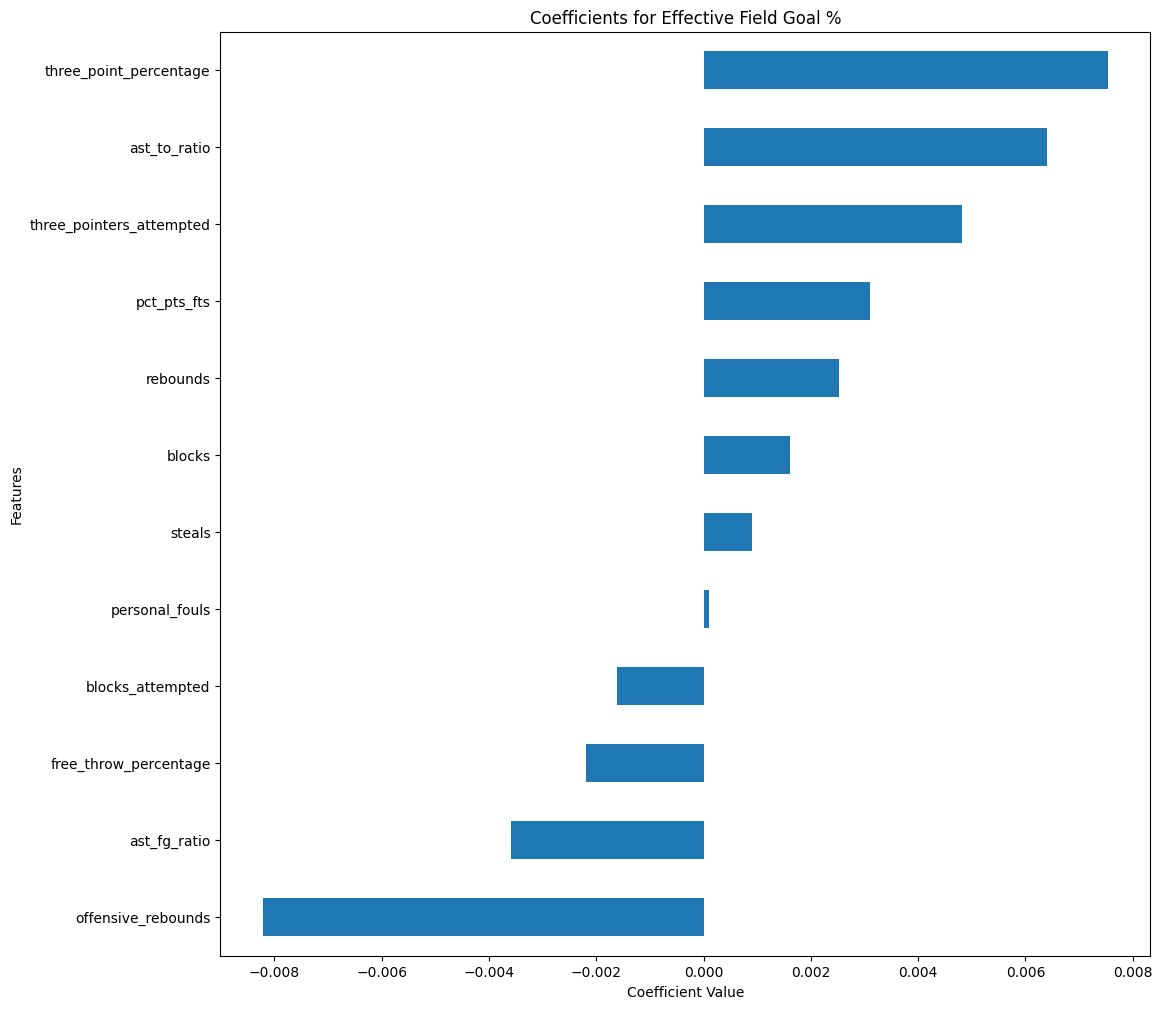

In [63]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(efg_era1_coefficients, 'Effective Field Goal %')

In [64]:
# Generate bootstrap coefficients 
bootstrap_results_efg_era1 = gen_bootstrap_coefficients(
    results_efg_era1['model'], results_efg_era1['X'], results_efg_era1['y'], results_efg_era1['feature_names']
)

Average Y: 0.48741196376152507
Average Training RMSE: 0.010958075121756056, Average Testing RMSE: 0.011419697325089241
Average Training R^2: 0.7088140651786644, Average Testing R^2: 0.6721819558558155
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
three_point_percentage    0.007074  0.000975  0.005150  0.008978
ast_to_ratio              0.006926  0.001226  0.004520  0.009311
three_pointers_attempted  0.004965  0.000942  0.003159  0.006843
pct_pts_fts               0.002782  0.000851  0.001174  0.004502
rebounds                  0.002433  0.001021  0.000416  0.004578
blocks                    0.001597  0.000755  0.000137  0.003074
steals                    0.000571  0.000746 -0.000749  0.002228
personal_fouls           -0.000149  0.000732 -0.001705  0.001251
blocks_attempted         -0.001243  0.000894 -0.002889  0.000250
free_throw_percentage    -0.002261  0.000718 -0.003617 -0.000912
ast_fg_ratio             -0.004476  0.000944 -0.006324 -0.0025

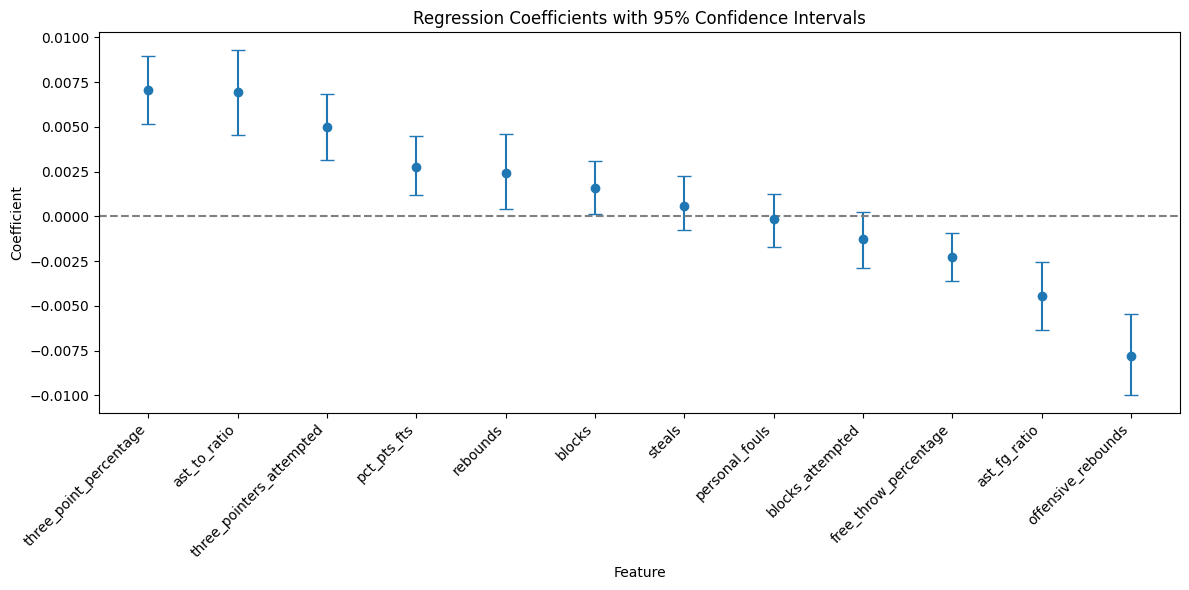

In [65]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_efg_era1)

In [66]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_efg_era1, efg_feats_era1)

A 0.007 unit increase in three_point_percentage results in an approximate 0.0024 (or 0.24 percentage points) change in the target variable.
A 0.030 unit increase in ast_to_ratio results in an approximate 0.0011 (or 0.11 percentage points) change in the target variable.
A 26.532 unit increase in three_pointers_attempted results in an approximate 0.0004 (or 0.04 percentage points) change in the target variable.
A 0.004 unit increase in pct_pts_fts results in an approximate 0.0006 (or 0.06 percentage points) change in the target variable.
A 67.434 unit increase in rebounds results in an approximate 0.0007 (or 0.07 percentage points) change in the target variable.
A 7.932 unit increase in blocks results in an approximate 0.0002 (or 0.02 percentage points) change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate -0.0012 (or -0.12 percentage points) change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate -0

In [67]:
# Continue with secondary feature regression analysis using rebounds as the target variable

In [68]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [69]:
# Drop the target variable from the features
reb_feats_era1 = era1_feats_master.drop(['rebounds'], axis=1)

reb_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   steals                    356 non-null    int64  
 5   blocks                    356 non-null    int64  
 6   blocks_attempted          356 non-null    int64  
 7   personal_fouls            356 non-null    int64  
 8   ast_to_ratio              356 non-null    float64
 9   pct_pts_fts               356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
 11  eFG%                      356 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.2 KB


In [70]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
reb_era1_feature_matrix, reb_era1_feat_str_correlations = gen_corr_matrix(reb_feats_era1)

reb_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [71]:
# Drop the offensive_rebounds feature
reb_feats_era1 = reb_feats_era1.drop(['offensive_rebounds'], axis=1)

reb_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   steals                    356 non-null    int64  
 4   blocks                    356 non-null    int64  
 5   blocks_attempted          356 non-null    int64  
 6   personal_fouls            356 non-null    int64  
 7   ast_to_ratio              356 non-null    float64
 8   pct_pts_fts               356 non-null    float64
 9   ast_fg_ratio              356 non-null    float64
 10  eFG%                      356 non-null    float64
dtypes: float64(6), int64(5)
memory usage: 33.4 KB


In [72]:
# Define the target variable for the dataset
y_reb_era1 = era1_feats_master['rebounds']

# Train the model for the dataset
results_reb_era1, reb_feats_era1 = gen_lasso_model(reb_feats_era1, y_reb_era1)

Best Alpha: 0.1
Y Measurables: 
count     356.000000
mean     3371.691011
std       221.686684
min      2560.000000
25%      3296.750000
50%      3414.500000
75%      3507.000000
max      3830.000000
Name: rebounds, dtype: float64
Training RMSE: 157.0071353750419, Testing RMSE: 148.3360832840909
Training R^2: 0.49061609939476547, Testing R^2: 0.5713089088565861
Non-zero Coefficients: 
personal_fouls              90.765872
ast_to_ratio                78.260761
blocks                      76.458165
three_pointers_attempted    42.069272
blocks_attempted            36.920215
pct_pts_fts                 22.219406
steals                      13.476854
three_point_percentage      12.488549
free_throw_percentage      -15.257527
eFG%                       -35.949953
ast_fg_ratio               -43.197597
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.786789
1     three_point_percentage  2.062761
2      free_throw_percentage  1.2

In [73]:
# With feature selection finalized, create a series of regression coefficients
reb_era1_coefficients = pd.Series(results_reb_era1['non_zero_coefficients'])

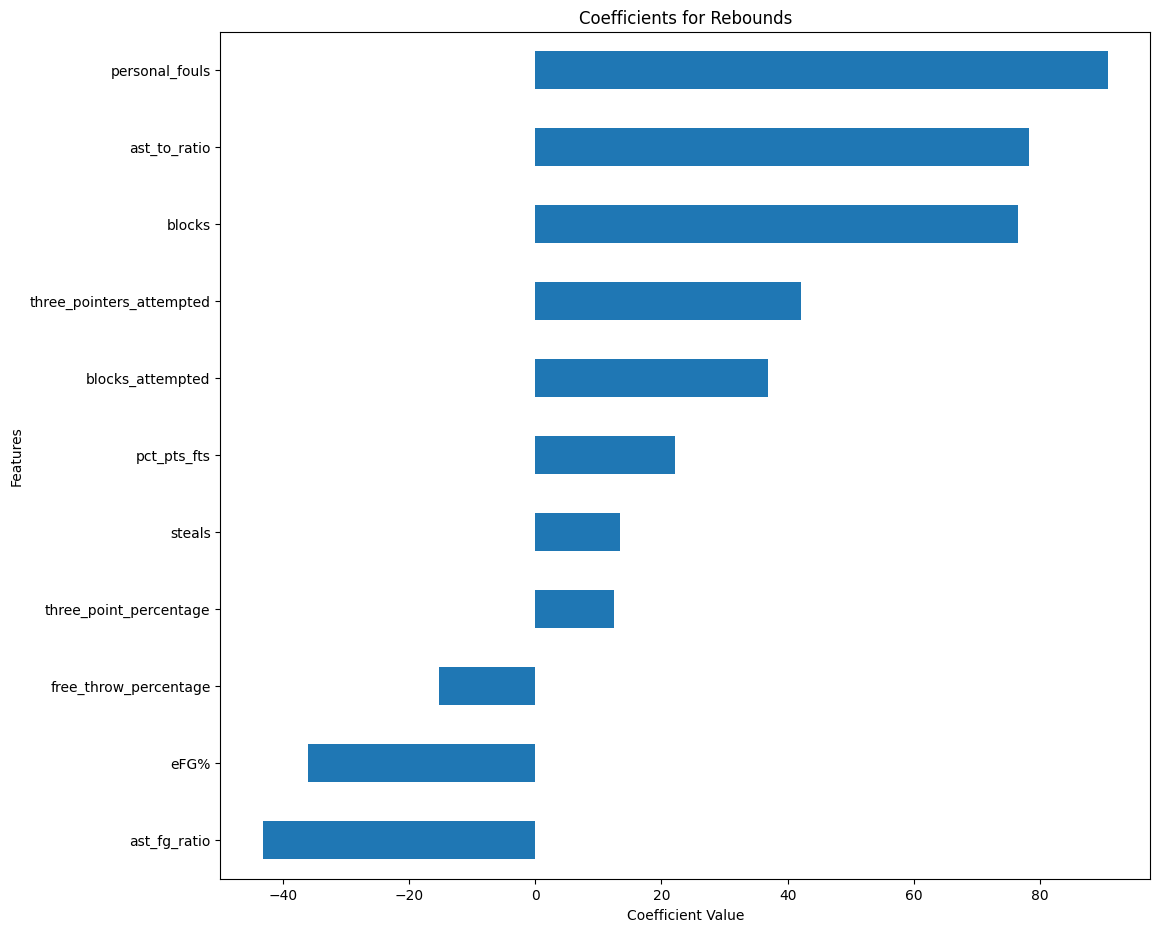

In [74]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(reb_era1_coefficients, 'Rebounds')

In [75]:
# Generate bootstrap coefficients 
bootstrap_results_reb_era1 = gen_bootstrap_coefficients(
    results_reb_era1['model'], results_reb_era1['X'], results_reb_era1['y'], results_reb_era1['feature_names']
)

Average Y: 3371.691011235955
Average Training RMSE: 151.34632974209654, Average Testing RMSE: 158.39798452775656
Average Training R^2: 0.5251531205766944, Average Testing R^2: 0.44558487050170653
Sorted Coefficients: 
                               Mean     StdDev   CI Lower    CI Upper
personal_fouls            92.216675  13.115489  66.184153  116.707600
ast_to_ratio              83.510769  15.915223  53.045139  114.497360
blocks                    77.027131   9.981711  57.468768   97.032601
three_pointers_attempted  43.958559  12.408270  19.207705   69.627194
blocks_attempted          40.264864  11.189578  18.601213   62.934520
pct_pts_fts               23.691146  12.153947  -0.832420   47.572407
steals                    11.742638  12.193774 -12.913863   35.567027
three_point_percentage     1.427818  13.025943 -24.963677   26.554195
free_throw_percentage    -20.102833  10.443047 -40.632334    0.418806
eFG%                     -31.613315  14.668488 -59.278038   -3.642416
ast_fg_ratio

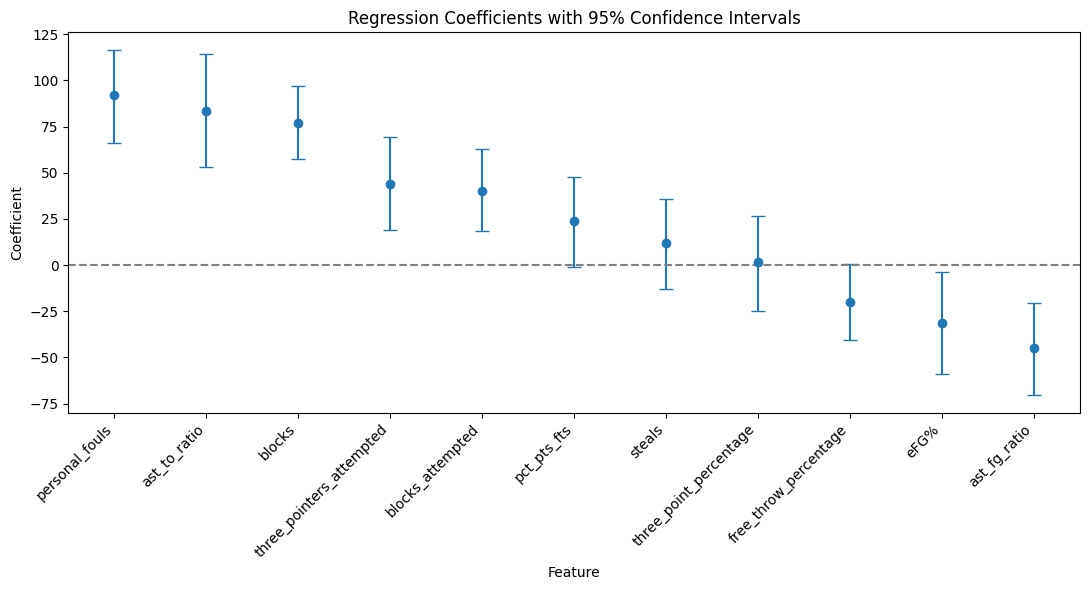

In [76]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_reb_era1)

In [77]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_reb_era1, reb_feats_era1, False)

A 34.673 unit increase in personal_fouls results in an approximate 17.403 change in the target variable.
A 0.030 unit increase in ast_to_ratio results in an approximate 13.522 change in the target variable.
A 7.932 unit increase in blocks results in an approximate 8.721 change in the target variable.
A 26.532 unit increase in three_pointers_attempted results in an approximate 3.739 change in the target variable.
A 7.932 unit increase in blocks_attempted results in an approximate 5.496 change in the target variable.
A 0.010 unit increase in eFG% results in an approximate -15.085 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate -12.873 change in the target variable.


In [78]:
# Continue with secondary feature regression analysis using pct_pts_fts as the target variable

In [79]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [80]:
# Drop the target variable from the features
ppfs_feats_era1 = era1_feats_master.drop(['pct_pts_fts'], axis=1)

ppfs_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
 11  eFG%                      356 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.2 KB


In [81]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
ppfs_era1_feature_matrix, ppfs_era1_feat_str_correlations = gen_corr_matrix(ppfs_feats_era1)

ppfs_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [82]:
# Define the target variable for the dataset
y_ppfs_era1 = era1_feats_master['pct_pts_fts']

# Train the model for the dataset
results_ppfs_era1, ppfs_feats_era1 = gen_lasso_model(ppfs_feats_era1, y_ppfs_era1)

Best Alpha: 0.0001
Y Measurables: 
count    356.000000
mean       0.192021
std        0.017625
min        0.133806
25%        0.181230
50%        0.190503
75%        0.205303
max        0.239480
Name: pct_pts_fts, dtype: float64
Training RMSE: 0.012448797277670055, Testing RMSE: 0.01496353591137314
Training R^2: 0.46899656518101596, Testing R^2: 0.3987635454203089
Non-zero Coefficients: 
personal_fouls              0.004968
eFG%                        0.004148
free_throw_percentage       0.004087
ast_fg_ratio                0.001603
rebounds                    0.001356
blocks                      0.000873
steals                      0.000667
offensive_rebounds          0.000479
blocks_attempted            0.000235
three_point_percentage     -0.003768
three_pointers_attempted   -0.004287
ast_to_ratio               -0.007121
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.788905
1     three_point_percentage  2.014984
2   

In [83]:
# With feature selection finalized, create a series of regression coefficients
ppfs_era1_coefficients = pd.Series(results_ppfs_era1['non_zero_coefficients'])

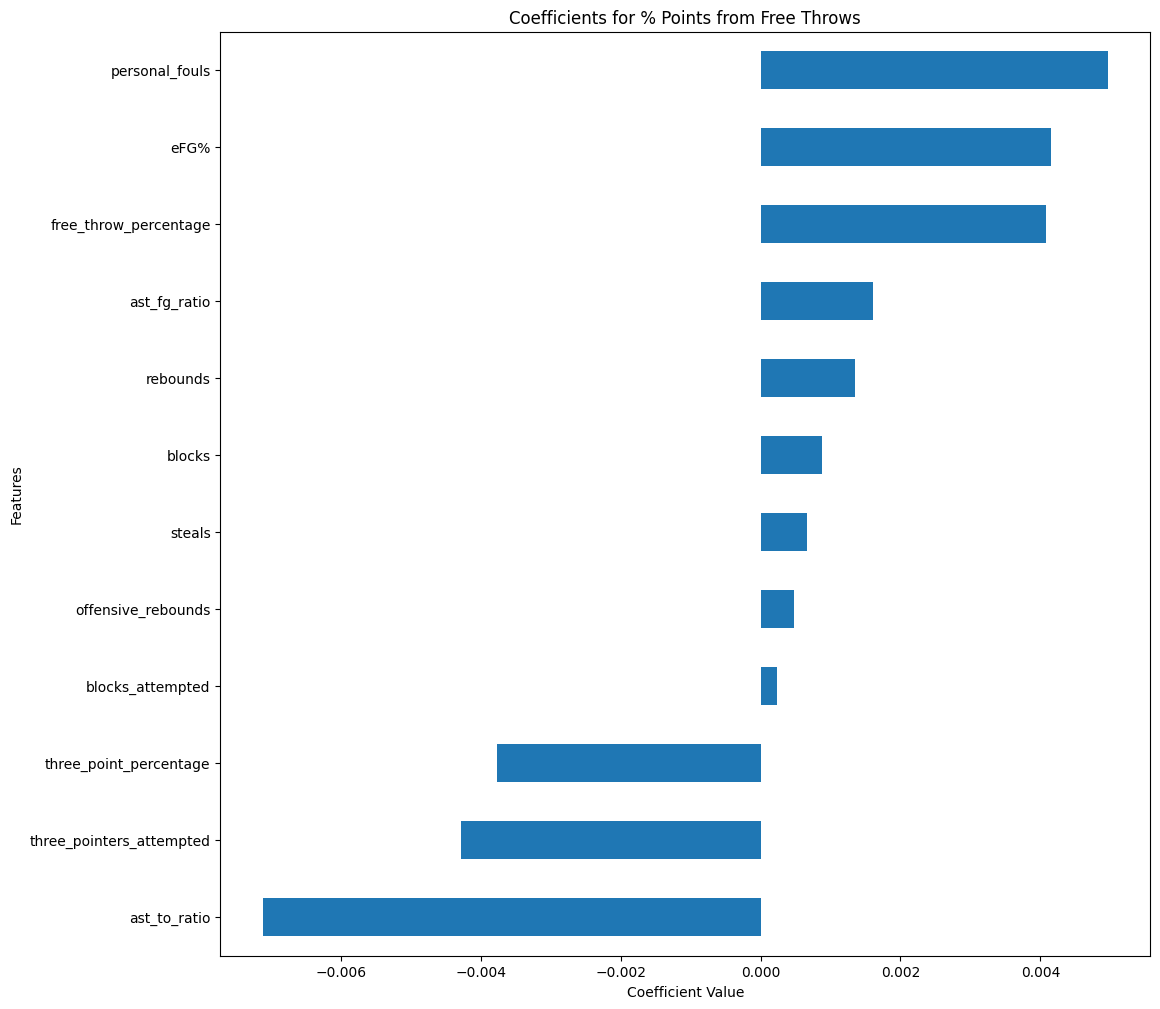

In [84]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(ppfs_era1_coefficients, '% Points from Free Throws')

In [85]:
# Generate bootstrap coefficients 
bootstrap_results_ppfs_era1 = gen_bootstrap_coefficients(
    results_ppfs_era1['model'], results_ppfs_era1['X'], results_ppfs_era1['y'], results_ppfs_era1['feature_names']
)

Average Y: 0.19202056513590432
Average Training RMSE: 0.012590836712252567, Average Testing RMSE: 0.013174119411418621
Average Training R^2: 0.48050816537650315, Average Testing R^2: 0.4173919971073851
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
personal_fouls            0.004789  0.000983  0.002838  0.006765
free_throw_percentage     0.004215  0.000814  0.002632  0.005743
eFG%                      0.004039  0.001190  0.001590  0.006202
ast_fg_ratio              0.002824  0.001144  0.000331  0.004956
rebounds                  0.001515  0.001231 -0.000520  0.003883
steals                    0.000913  0.000845 -0.000569  0.002599
blocks                    0.000723  0.000819 -0.000866  0.002369
offensive_rebounds        0.000695  0.001234 -0.001794  0.003381
blocks_attempted         -0.000158  0.000997 -0.002128  0.001726
three_point_percentage   -0.002616  0.001223 -0.004863 -0.000196
three_pointers_attempted -0.004169  0.000976 -0.006083 -0.002

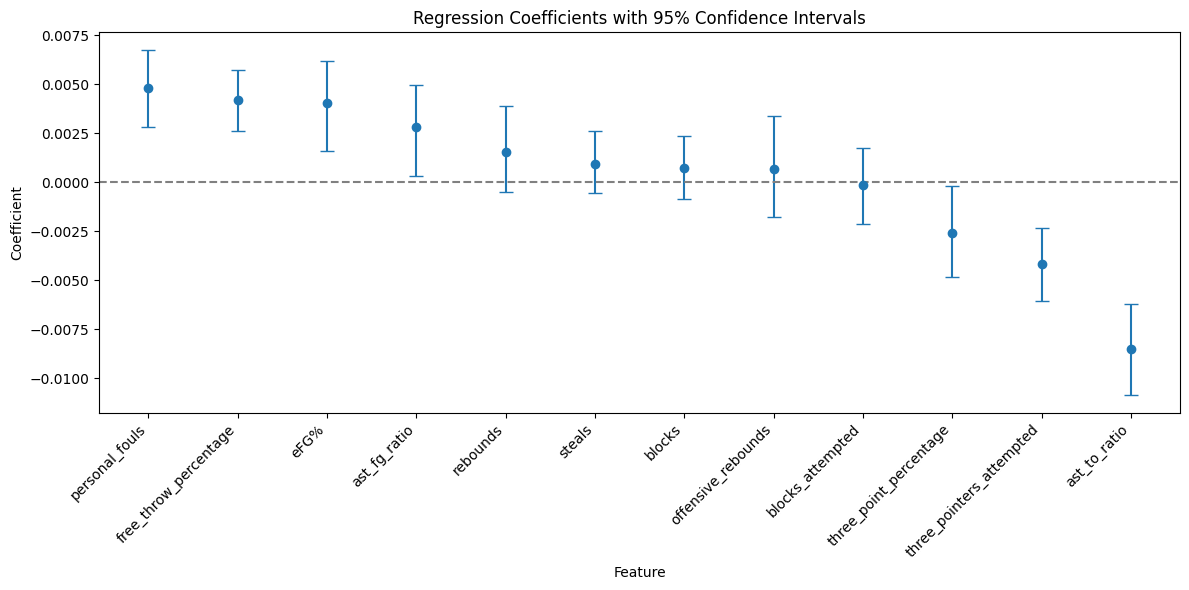

In [86]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_ppfs_era1)

In [87]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_ppfs_era1, ppfs_feats_era1)

A 34.673 unit increase in personal_fouls results in an approximate 0.0009 (or 0.09 percentage points) change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate 0.0022 (or 0.22 percentage points) change in the target variable.
A 0.010 unit increase in eFG% results in an approximate 0.0019 (or 0.19 percentage points) change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 0.0008 (or 0.08 percentage points) change in the target variable.
A 0.007 unit increase in three_point_percentage results in an approximate -0.0009 (or -0.09 percentage points) change in the target variable.
A 26.532 unit increase in three_pointers_attempted results in an approximate -0.0004 (or -0.04 percentage points) change in the target variable.
A 0.030 unit increase in ast_to_ratio results in an approximate -0.0014 (or -0.14 percentage points) change in the target variable.


In [88]:
# Continue with secondary feature regression analysis using ast_to_ratio as the target variable

In [89]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [90]:
# Drop the target variable from the features
atr_feats_era1 = era1_feats_master.drop(['ast_to_ratio'], axis=1)

atr_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   pct_pts_fts               356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
 11  eFG%                      356 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.2 KB


In [91]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
atr_era1_feature_matrix, atr_era1_feat_str_correlations = gen_corr_matrix(atr_feats_era1)

atr_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [92]:
# Define the target variable for the dataset
y_atr_era1 = era1_feats_master['ast_to_ratio']

# Train the model for the dataset
results_atr_era1, atr_feats_era1 = gen_lasso_model(atr_feats_era1, y_atr_era1)

Best Alpha: 0.001
Y Measurables: 
count    356.000000
mean       1.477720
std        0.182787
min        1.013112
25%        1.341769
50%        1.465267
75%        1.590646
max        2.117078
Name: ast_to_ratio, dtype: float64
Training RMSE: 0.1028991388660169, Testing RMSE: 0.09596311169150872
Training R^2: 0.678111852996111, Testing R^2: 0.7339767403553783
Non-zero Coefficients: 
ast_fg_ratio              0.101699
eFG%                      0.063389
offensive_rebounds        0.046023
free_throw_percentage     0.045179
rebounds                  0.013098
three_point_percentage    0.008210
steals                    0.006343
blocks                   -0.002692
personal_fouls           -0.023460
blocks_attempted         -0.036951
pct_pts_fts              -0.049885
dtype: float64
Variance Inflation Factors: 
                   feature       vif
0   three_point_percentage  2.052045
1    free_throw_percentage  1.139724
2       offensive_rebounds  3.375001
3                 rebounds  2.944014

In [93]:
# With feature selection finalized, create a series of regression coefficients
atr_era1_coefficients = pd.Series(results_atr_era1['non_zero_coefficients'])

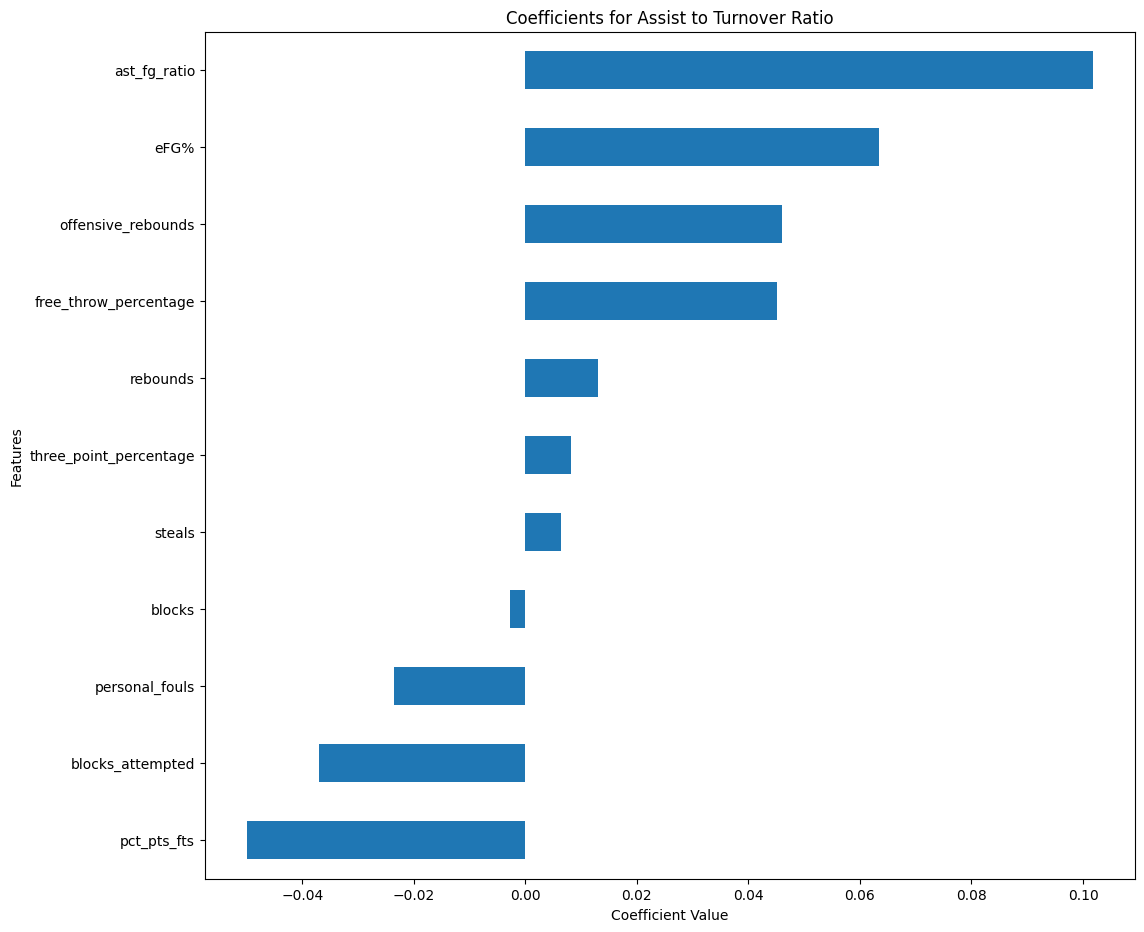

In [94]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(atr_era1_coefficients, 'Assist to Turnover Ratio')

In [95]:
# Generate bootstrap coefficients 
bootstrap_results_atr_era1 = gen_bootstrap_coefficients(
    results_atr_era1['model'], results_atr_era1['X'], results_atr_era1['y'], results_atr_era1['feature_names']
)

Average Y: 1.4777201864559948
Average Training RMSE: 0.09900773918361705, Average Testing RMSE: 0.1027306769024699
Average Training R^2: 0.7024964440438835, Average Testing R^2: 0.6688464795144824
Sorted Coefficients: 
                            Mean    StdDev  CI Lower  CI Upper
ast_fg_ratio            0.098243  0.006263  0.086115  0.111114
eFG%                    0.062487  0.010025  0.042871  0.081658
offensive_rebounds      0.043544  0.011360  0.020132  0.065584
free_throw_percentage   0.042202  0.006752  0.028981  0.055330
rebounds                0.015732  0.009212  0.000000  0.034523
steals                  0.009824  0.006459 -0.000165  0.022316
three_point_percentage  0.008524  0.007974 -0.005098  0.024961
blocks                 -0.005417  0.005774 -0.017687  0.004368
personal_fouls         -0.025646  0.007281 -0.040545 -0.011541
blocks_attempted       -0.035556  0.007827 -0.050950 -0.019981
pct_pts_fts            -0.052578  0.006938 -0.065477 -0.038435


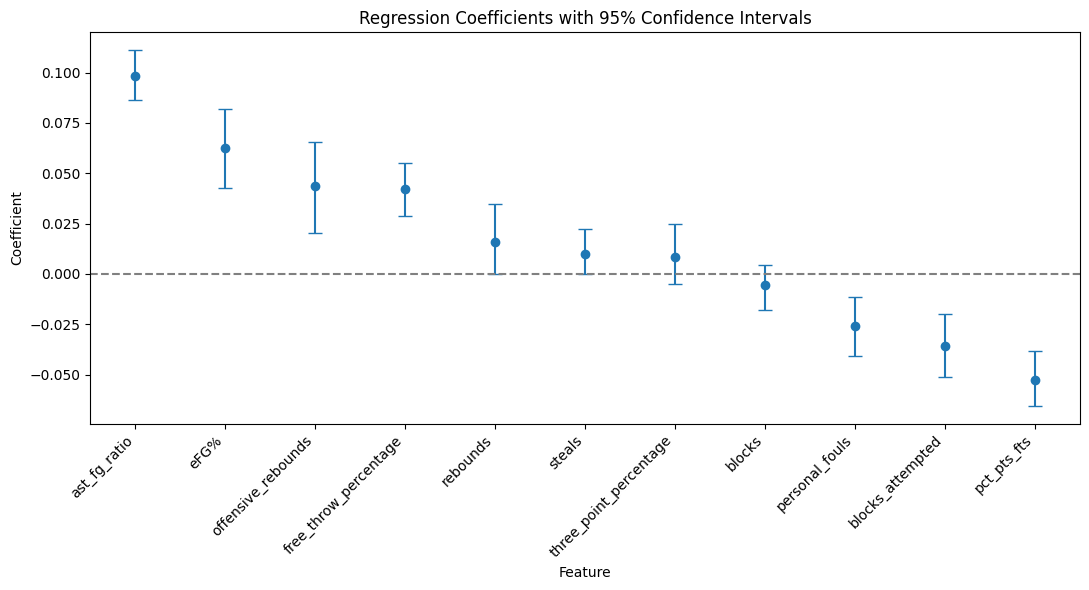

In [96]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_atr_era1)

In [97]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_atr_era1, atr_feats_era1, False)

A 0.012 unit increase in ast_fg_ratio results in an approximate 0.028 change in the target variable.
A 0.010 unit increase in eFG% results in an approximate 0.030 change in the target variable.
A 18.564 unit increase in offensive_rebounds results in an approximate 0.007 change in the target variable.
A 0.015 unit increase in free_throw_percentage results in an approximate 0.023 change in the target variable.
A 34.673 unit increase in personal_fouls results in an approximate -0.005 change in the target variable.
A 7.932 unit increase in blocks_attempted results in an approximate -0.005 change in the target variable.
A 0.004 unit increase in pct_pts_fts results in an approximate -0.011 change in the target variable.


In [98]:
# Continue with secondary feature regression analysis using steals as the target variable

In [99]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [100]:
# Drop the target variable from the features
steals_feats_era1 = era1_feats_master.drop(['steals'], axis=1)

steals_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   blocks                    356 non-null    int64  
 6   blocks_attempted          356 non-null    int64  
 7   personal_fouls            356 non-null    int64  
 8   ast_to_ratio              356 non-null    float64
 9   pct_pts_fts               356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
 11  eFG%                      356 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.2 KB


In [101]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
steals_era1_feature_matrix, steals_era1_feat_str_correlations = gen_corr_matrix(steals_feats_era1)

steals_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [102]:
# Define the target variable for the dataset
y_steals_era1 = era1_feats_master['steals']

# Train the model for the dataset
results_steals_era1, steals_feats_era1 = gen_lasso_model(steals_feats_era1, y_steals_era1)

Best Alpha: 0.1
Y Measurables: 
count    356.000000
mean     605.536517
std       75.575250
min      390.000000
25%      556.000000
50%      599.000000
75%      654.000000
max      844.000000
Name: steals, dtype: float64
Training RMSE: 64.8241631985781, Testing RMSE: 60.27806809972706
Training R^2: 0.2869963541247387, Testing R^2: 0.260625116606481
Non-zero Coefficients: 
personal_fouls              16.872588
blocks_attempted            16.808258
offensive_rebounds          16.441083
ast_fg_ratio                10.287738
eFG%                         8.909313
three_pointers_attempted     8.608685
ast_to_ratio                 7.222940
pct_pts_fts                  4.144778
blocks                       2.751353
rebounds                    -1.756419
three_point_percentage      -9.281796
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.886209
1     three_point_percentage  2.012032
2         offensive_rebounds  3.369606
3      

In [103]:
# With feature selection finalized, create a series of regression coefficients
steals_era1_coefficients = pd.Series(results_steals_era1['non_zero_coefficients'])

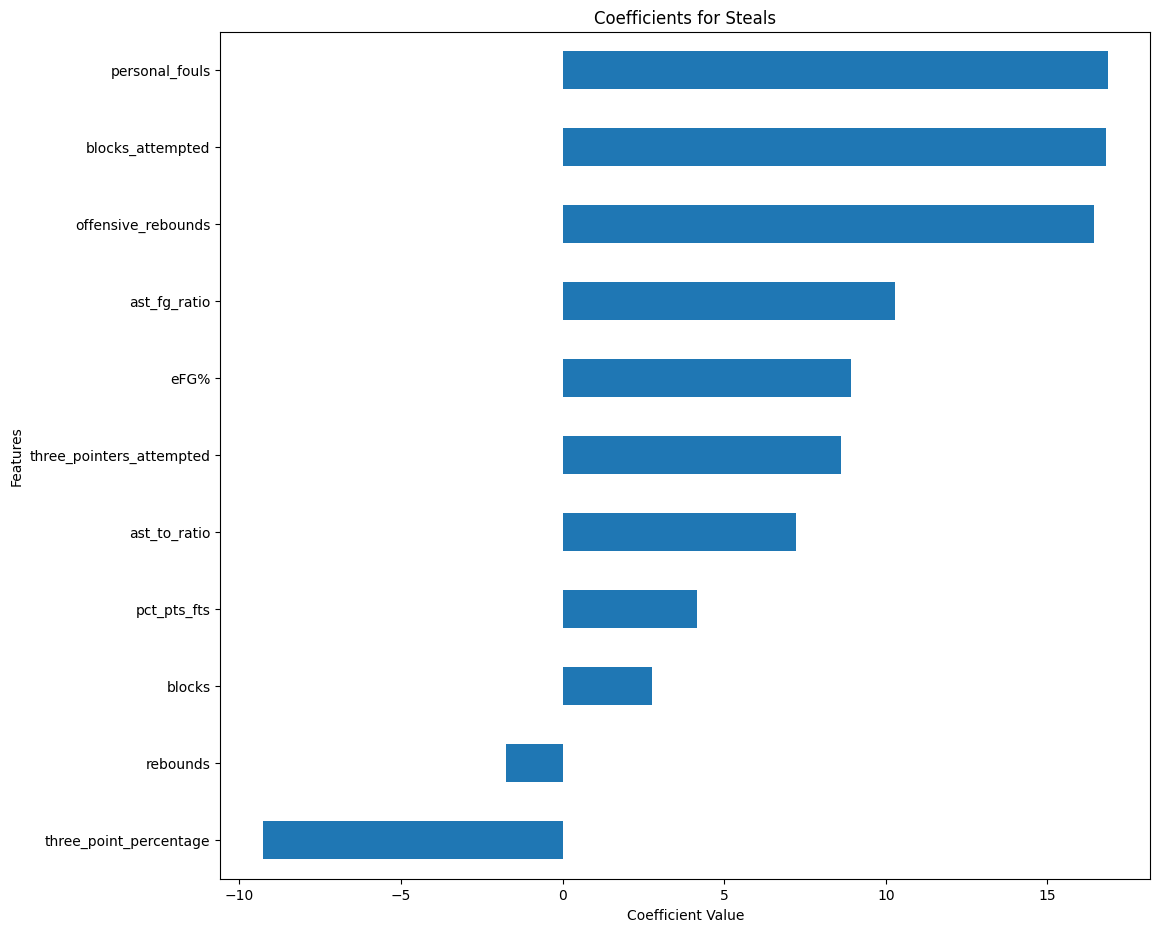

In [104]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(steals_era1_coefficients, 'Steals')

In [105]:
# Generate bootstrap coefficients 
bootstrap_results_steals_era1 = gen_bootstrap_coefficients(
    results_steals_era1['model'], results_steals_era1['X'], results_steals_era1['y'], results_steals_era1['feature_names']
)

Average Y: 605.5365168539325
Average Training RMSE: 62.43406342085383, Average Testing RMSE: 65.13256068325717
Average Training R^2: 0.31533531308576224, Average Testing R^2: 0.237750366517877
Sorted Coefficients: 
                               Mean    StdDev   CI Lower   CI Upper
blocks_attempted          18.818673  5.396881   8.733554  30.172658
offensive_rebounds        16.247215  6.988606   1.943231  30.393950
personal_fouls            14.841511  5.982706   2.651655  26.303029
ast_to_ratio              12.037800  6.096265   0.251198  23.660562
three_pointers_attempted   8.316486  5.726256  -2.507320  19.815165
ast_fg_ratio               7.945219  5.347976  -2.598720  18.001963
pct_pts_fts                5.940061  4.755980  -3.283388  15.791676
eFG%                       5.163816  6.908874  -9.038961  18.490683
blocks                     2.717166  4.676277  -7.169408  11.847486
rebounds                  -3.307745  6.836736 -16.472815   9.869241
three_point_percentage    -8.178173  

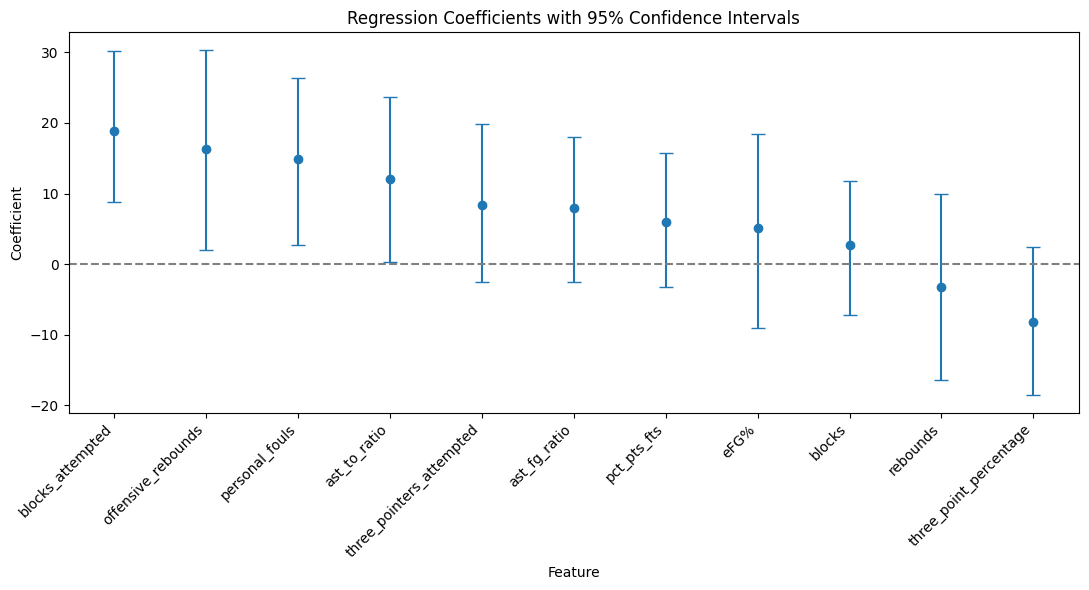

In [106]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_steals_era1)

In [107]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_steals_era1, steals_feats_era1, False)

A 7.932 unit increase in blocks_attempted results in an approximate 2.569 change in the target variable.
A 18.564 unit increase in offensive_rebounds results in an approximate 2.672 change in the target variable.
A 34.673 unit increase in personal_fouls results in an approximate 2.801 change in the target variable.
A 0.030 unit increase in ast_to_ratio results in an approximate 1.949 change in the target variable.


In [108]:
# Continue with secondary feature regression analysis using three_point_percentage as the target variable

In [109]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [110]:
# Drop the target variable from the features
tpp_feats_era1 = era1_feats_master.drop(['three_point_percentage'], axis=1)

tpp_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   free_throw_percentage     356 non-null    float64
 2   offensive_rebounds        356 non-null    int64  
 3   rebounds                  356 non-null    int64  
 4   steals                    356 non-null    int64  
 5   blocks                    356 non-null    int64  
 6   blocks_attempted          356 non-null    int64  
 7   personal_fouls            356 non-null    int64  
 8   ast_to_ratio              356 non-null    float64
 9   pct_pts_fts               356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
 11  eFG%                      356 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.2 KB


In [111]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
tpp_era1_feature_matrix, tpp_era1_feat_str_correlations = gen_corr_matrix(tpp_feats_era1)

tpp_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [112]:
# Drop the eFG% feature from the dataset
tpp_feats_era1 = tpp_feats_era1.drop(['eFG%'], axis=1)

tpp_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   free_throw_percentage     356 non-null    float64
 2   offensive_rebounds        356 non-null    int64  
 3   rebounds                  356 non-null    int64  
 4   steals                    356 non-null    int64  
 5   blocks                    356 non-null    int64  
 6   blocks_attempted          356 non-null    int64  
 7   personal_fouls            356 non-null    int64  
 8   ast_to_ratio              356 non-null    float64
 9   pct_pts_fts               356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 33.4 KB


In [113]:
# Define the target variable for the dataset
y_tpp_era1 = era1_feats_master['three_point_percentage']

# Train the model for the dataset
results_tpp_era1, tpp_feats_era1 = gen_lasso_model(tpp_feats_era1, y_tpp_era1)

Best Alpha: 0.0001
Y Measurables: 
count    356.000000
mean       0.353764
std        0.020598
min        0.278000
25%        0.342000
50%        0.353000
75%        0.367000
max        0.412000
Name: three_point_percentage, dtype: float64
Training RMSE: 0.015956412480662128, Testing RMSE: 0.016159334910305224
Training R^2: 0.3941091279932718, Testing R^2: 0.3976204347677852
Non-zero Coefficients: 
ast_to_ratio                0.006791
three_pointers_attempted    0.003998
personal_fouls              0.003796
rebounds                    0.003668
blocks                      0.001451
free_throw_percentage       0.001013
blocks_attempted           -0.000246
steals                     -0.001260
pct_pts_fts                -0.003005
ast_fg_ratio               -0.003644
offensive_rebounds         -0.006899
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.621674
1      free_throw_percentage  1.270920
2         offensive_rebounds  

In [114]:
# With feature selection finalized, create a series of regression coefficients
tpp_era1_coefficients = pd.Series(results_tpp_era1['non_zero_coefficients'])

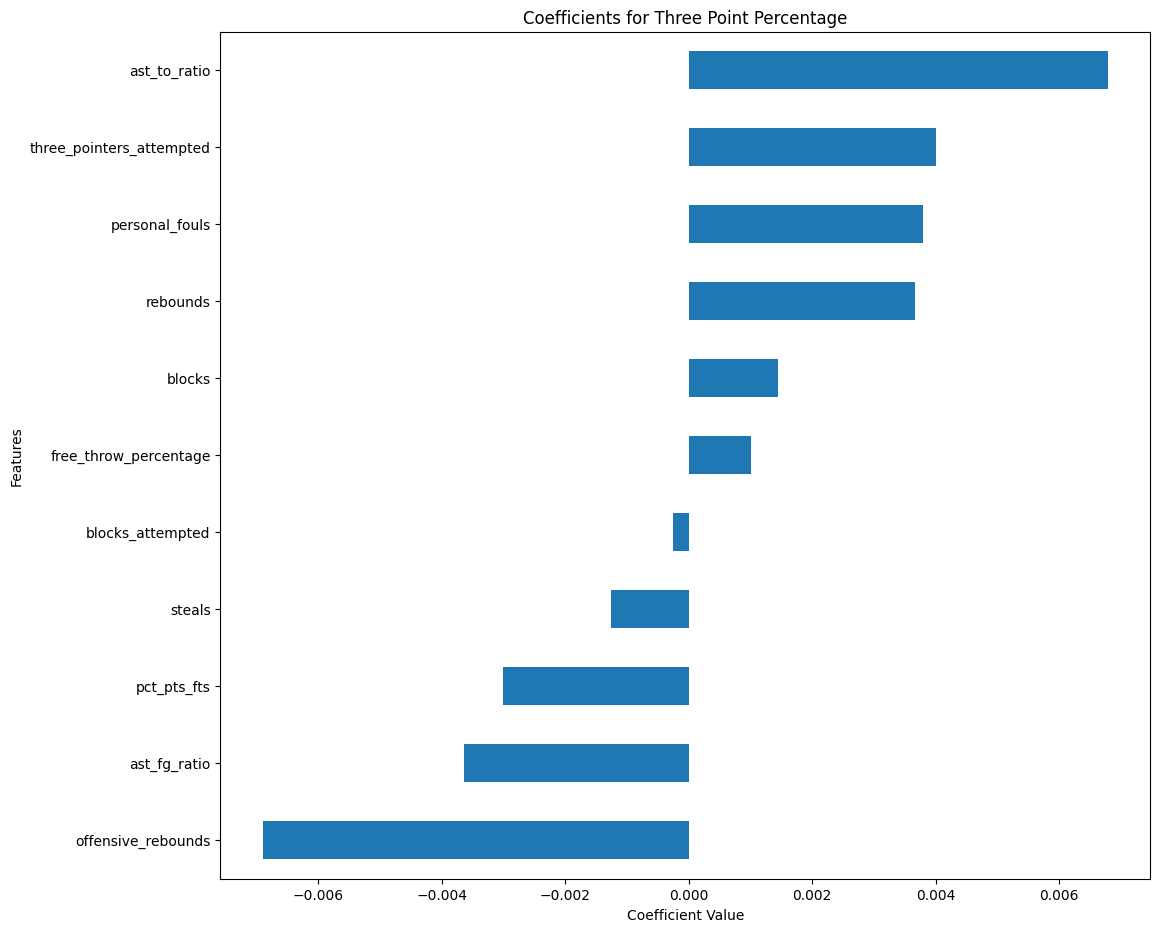

In [115]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(tpp_era1_coefficients, 'Three Point Percentage')

In [116]:
# Generate bootstrap coefficients 
bootstrap_results_tpp_era1 = gen_bootstrap_coefficients(
    results_tpp_era1['model'], results_tpp_era1['X'], results_tpp_era1['y'], results_tpp_era1['feature_names']
)

Average Y: 0.35376404494382024
Average Training RMSE: 0.015508061515951297, Average Testing RMSE: 0.016148637925500715
Average Training R^2: 0.42577600091663714, Average Testing R^2: 0.3603679454836789
Sorted Coefficients: 
                              Mean    StdDev  CI Lower  CI Upper
ast_to_ratio              0.006700  0.001467  0.003791  0.009525
three_pointers_attempted  0.004891  0.001271  0.002335  0.007456
personal_fouls            0.004235  0.001386  0.001515  0.007024
rebounds                  0.002666  0.001579  0.000000  0.005764
blocks                    0.001880  0.001027  0.000000  0.004029
free_throw_percentage     0.001076  0.001021 -0.000792  0.003139
blocks_attempted         -0.001004  0.001144 -0.003167  0.001205
steals                   -0.001371  0.001077 -0.003428  0.000613
pct_pts_fts              -0.001600  0.001269 -0.003983  0.000779
ast_fg_ratio             -0.002838  0.001378 -0.005629 -0.000074
offensive_rebounds       -0.006624  0.001641 -0.009891 -0.003

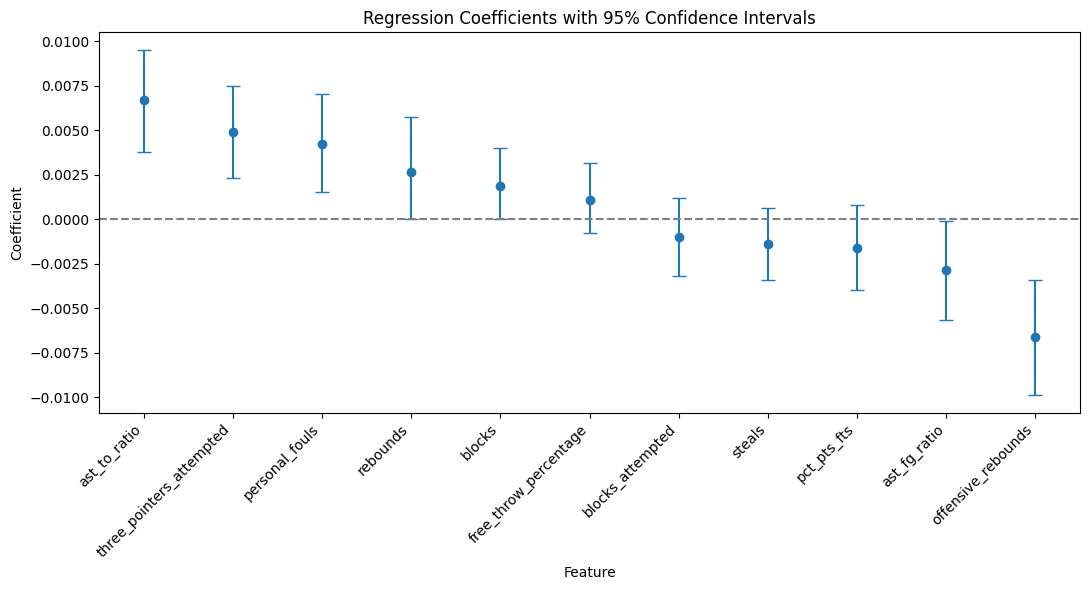

In [117]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_tpp_era1)

In [118]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_tpp_era1, tpp_feats_era1)

A 0.030 unit increase in ast_to_ratio results in an approximate 0.0011 (or 0.11 percentage points) change in the target variable.
A 26.532 unit increase in three_pointers_attempted results in an approximate 0.0004 (or 0.04 percentage points) change in the target variable.
A 34.673 unit increase in personal_fouls results in an approximate 0.0008 (or 0.08 percentage points) change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate -0.0008 (or -0.08 percentage points) change in the target variable.
A 18.564 unit increase in offensive_rebounds results in an approximate -0.0011 (or -0.11 percentage points) change in the target variable.


In [119]:
# Continue with secondary feature regression analysis using blocks as the target variable

In [120]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [121]:
# Drop the target variable from the features
blocks_feats_era1 = era1_feats_master.drop(['blocks'], axis=1)

blocks_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks_attempted          356 non-null    int64  
 7   personal_fouls            356 non-null    int64  
 8   ast_to_ratio              356 non-null    float64
 9   pct_pts_fts               356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
 11  eFG%                      356 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.2 KB


In [122]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
blocks_era1_feature_matrix, blocks_era1_feat_str_correlations = gen_corr_matrix(blocks_feats_era1)

blocks_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [123]:
# Define the target variable for the dataset
y_blocks_era1 = era1_feats_master['blocks']

# Train the model for the dataset
results_blocks_era1, blocks_feats_era1 = gen_lasso_model(blocks_feats_era1, y_blocks_era1)

Best Alpha: 0.1
Y Measurables: 
count    356.000000
mean     396.620787
std       70.164591
min      204.000000
25%      346.750000
50%      392.000000
75%      446.000000
max      576.000000
Name: blocks, dtype: float64
Training RMSE: 58.19916707853423, Testing RMSE: 65.3596623835081
Training R^2: 0.2838296801805147, Testing R^2: 0.23596379179759475
Non-zero Coefficients: 
rebounds                    32.822142
eFG%                        12.960440
ast_fg_ratio                 5.639818
pct_pts_fts                  4.685418
steals                       2.491213
three_point_percentage       1.085560
blocks_attempted             0.735527
offensive_rebounds           0.247976
ast_to_ratio                -3.552182
free_throw_percentage       -7.161941
personal_fouls              -9.361781
three_pointers_attempted   -20.477472
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.785288
1     three_point_percentage  2.062388
2     

In [124]:
# With feature selection finalized, create a series of regression coefficients
blocks_era1_coefficients = pd.Series(results_blocks_era1['non_zero_coefficients'])

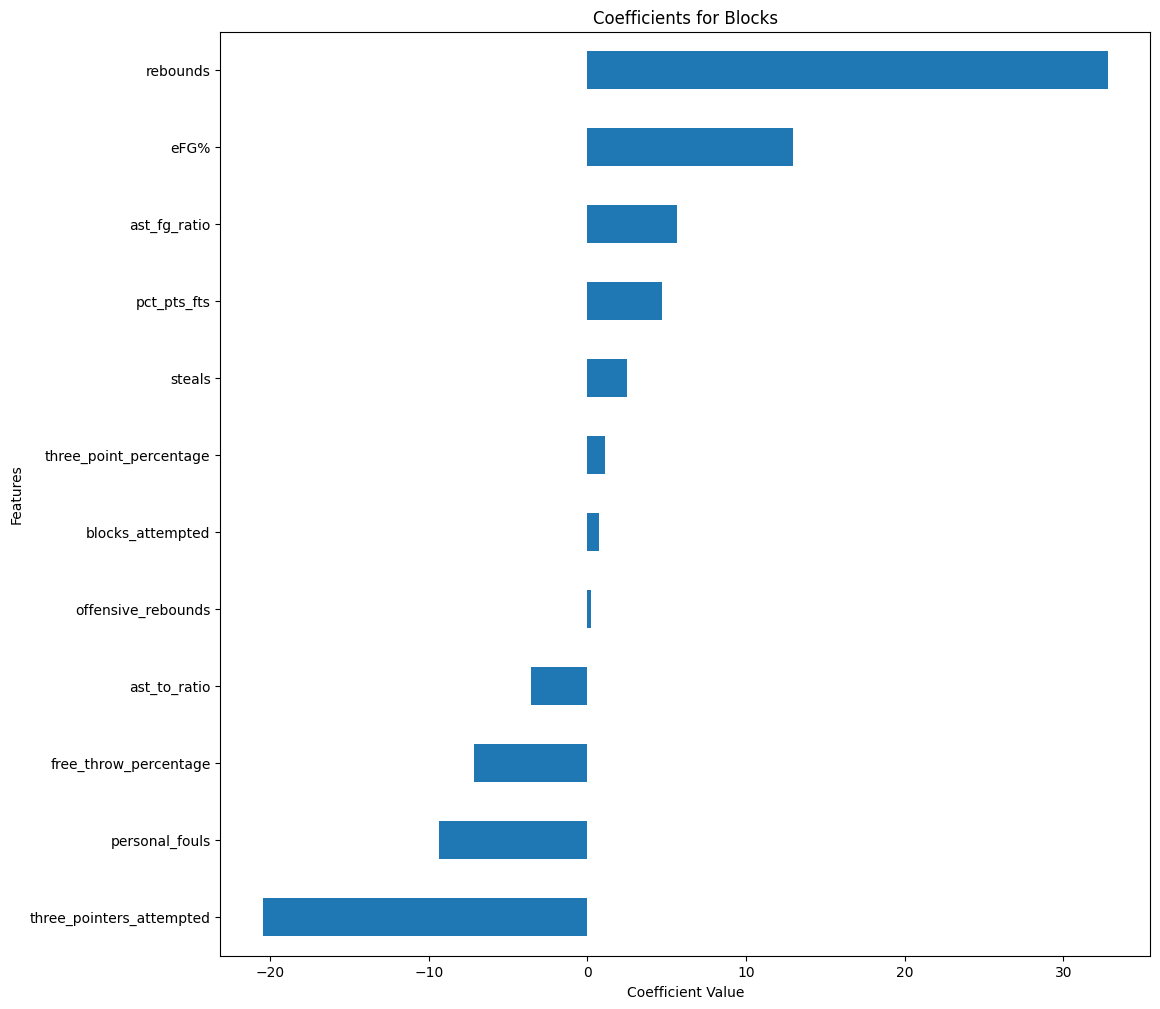

In [125]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(blocks_era1_coefficients, 'Blocks')

In [126]:
# Generate bootstrap coefficients 
bootstrap_results_blocks_era1 = gen_bootstrap_coefficients(
    results_blocks_era1['model'], results_blocks_era1['X'], results_blocks_era1['y'], results_blocks_era1['feature_names']
)

Average Y: 396.6207865168539
Average Training RMSE: 58.09625635784714, Average Testing RMSE: 60.53794113145089
Average Training R^2: 0.30875086167132115, Average Testing R^2: 0.23437464233633545
Sorted Coefficients: 
                               Mean    StdDev   CI Lower   CI Upper
rebounds                  35.048201  5.577210  23.562532  45.770954
eFG%                      13.066056  6.436218   0.596154  26.192109
ast_fg_ratio               8.862946  5.185476  -1.178343  18.831312
pct_pts_fts                3.733762  4.713273  -5.249194  13.344082
three_point_percentage     3.441601  4.833441  -6.007897  12.748167
steals                     2.847159  4.401596  -5.775506  11.474616
offensive_rebounds         0.841648  5.940476 -10.892950  12.215255
blocks_attempted          -3.420624  4.356818 -12.255773   4.904633
free_throw_percentage     -5.952105  3.932694 -13.656314   1.450875
ast_to_ratio              -6.514168  6.281243 -19.086896   5.149630
personal_fouls           -10.820803

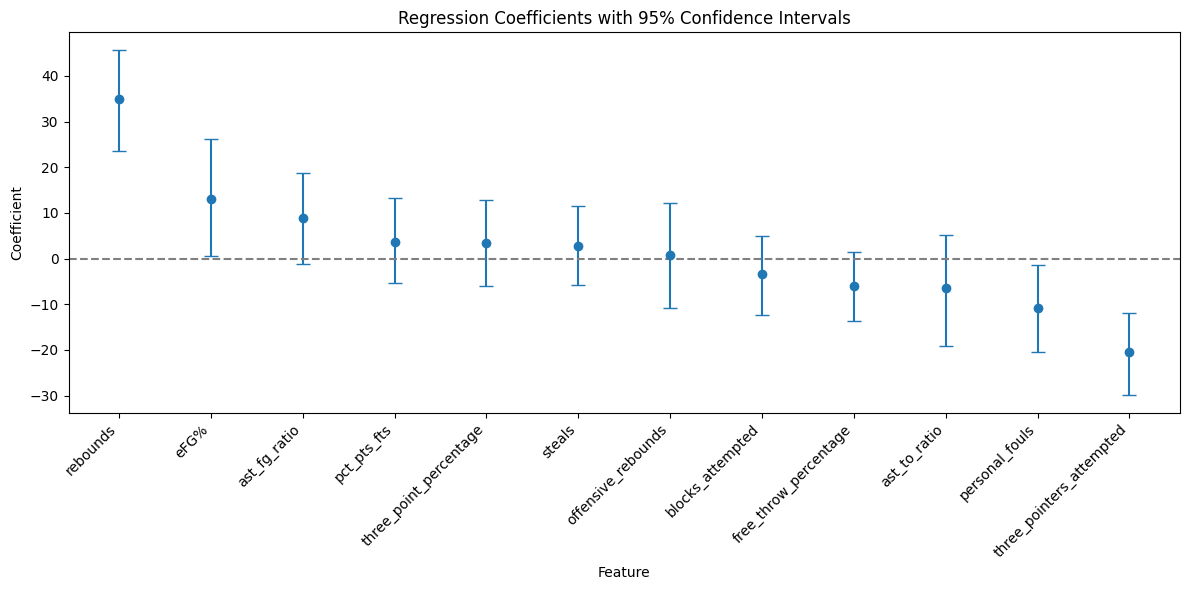

In [127]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_blocks_era1)

In [128]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_blocks_era1, blocks_feats_era1, False)

A 67.434 unit increase in rebounds results in an approximate 10.676 change in the target variable.
A 0.010 unit increase in eFG% results in an approximate 6.235 change in the target variable.
A 34.673 unit increase in personal_fouls results in an approximate -2.042 change in the target variable.
A 26.532 unit increase in three_pointers_attempted results in an approximate -1.739 change in the target variable.


In [129]:
# Continue with secondary feature regression analysis using blocks_attempted as the target variable

In [130]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [131]:
# Drop the target variable from the features
ba_feats_era1 = era1_feats_master.drop(['blocks_attempted'], axis=1)

ba_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   personal_fouls            356 non-null    int64  
 8   ast_to_ratio              356 non-null    float64
 9   pct_pts_fts               356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
 11  eFG%                      356 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.2 KB


In [132]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
ba_era1_feature_matrix, ba_era1_feat_str_correlations = gen_corr_matrix(ba_feats_era1)

ba_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [133]:
# Define the target variable for the dataset
y_ba_era1 = era1_feats_master['blocks_attempted']

# Train the model for the dataset
results_ba_era1, ba_feats_era1 = gen_lasso_model(ba_feats_era1, y_ba_era1)

Best Alpha: 0.1
Y Measurables: 
count    356.000000
mean     396.620787
std       58.192294
min      246.000000
25%      356.000000
50%      399.000000
75%      435.250000
max      560.000000
Name: blocks_attempted, dtype: float64
Training RMSE: 43.850976209098036, Testing RMSE: 39.95683384300599
Training R^2: 0.43770401000012693, Testing R^2: 0.5013901727232856
Non-zero Coefficients: 
offensive_rebounds          15.351393
ast_fg_ratio                12.436471
steals                      10.031564
personal_fouls               4.994367
free_throw_percentage        3.069142
rebounds                     2.637613
three_point_percentage       2.277655
pct_pts_fts                  0.760071
blocks                       0.382525
three_pointers_attempted     0.379521
eFG%                        -8.589822
ast_to_ratio               -21.452644
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.903388
1     three_point_percentage  2.0

In [134]:
# With feature selection finalized, create a series of regression coefficients
ba_era1_coefficients = pd.Series(results_ba_era1['non_zero_coefficients'])

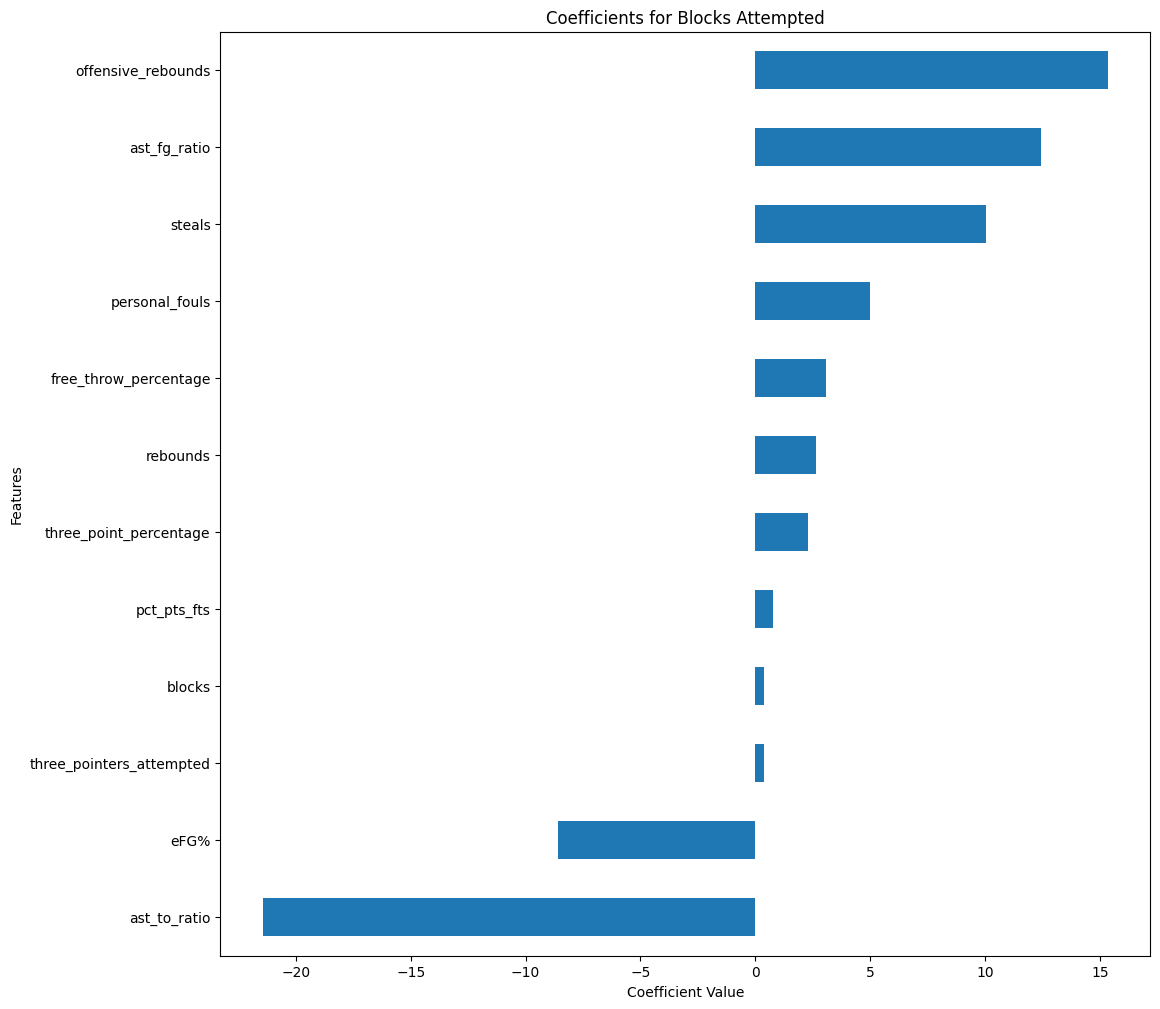

In [135]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(ba_era1_coefficients, 'Blocks Attempted')

In [136]:
# Generate bootstrap coefficients 
bootstrap_results_ba_era1 = gen_bootstrap_coefficients(
    results_ba_era1['model'], results_ba_era1['X'], results_ba_era1['y'], results_ba_era1['feature_names']
)

Average Y: 396.6207865168539
Average Training RMSE: 41.96029174158584, Average Testing RMSE: 43.78518929140186
Average Training R^2: 0.4746023648811915, Average Testing R^2: 0.41440778808316975
Sorted Coefficients: 
                               Mean    StdDev   CI Lower   CI Upper
offensive_rebounds        16.724480  4.734053   7.859309  25.939474
steals                    10.785218  2.934452   5.060195  16.686644
ast_fg_ratio              10.598281  3.468360   4.002355  16.761165
personal_fouls             5.143450  3.170179  -0.969252  11.148998
free_throw_percentage      3.310280  3.316563  -3.256308   9.813212
rebounds                   2.542615  4.288502  -5.841677  11.102842
three_point_percentage    -0.140927  3.523325  -7.044895   6.904864
pct_pts_fts               -0.863142  3.527154  -8.197958   5.991090
three_pointers_attempted  -1.132770  3.420684  -7.807919   5.638375
blocks                    -2.102745  2.827021  -7.621473   3.247617
eFG%                      -6.449360 

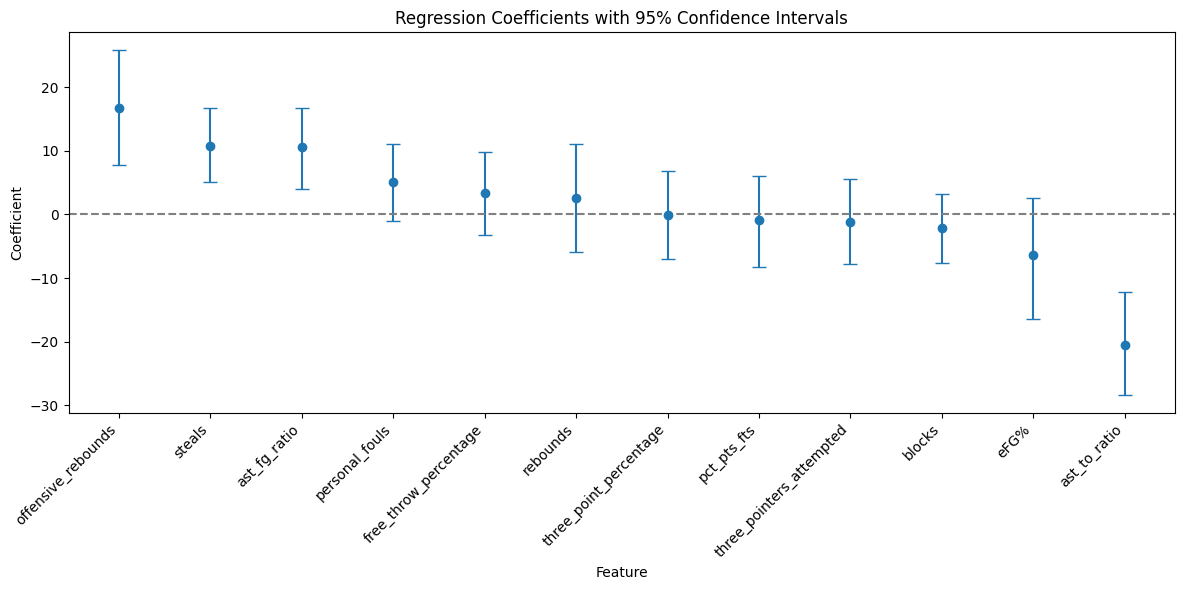

In [137]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_ba_era1)

In [138]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_ba_era1, ba_feats_era1, False)

A 18.564 unit increase in offensive_rebounds results in an approximate 2.751 change in the target variable.
A 12.111 unit increase in steals results in an approximate 1.731 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 3.040 change in the target variable.
A 0.030 unit increase in ast_to_ratio results in an approximate -3.314 change in the target variable.


In [139]:
# Continue with secondary feature regression analysis using personal_fouls as the target variable

In [140]:
# Check the df_feats_master DataFrame
era1_feats_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   personal_fouls            356 non-null    int64  
 9   ast_to_ratio              356 non-null    float64
 10  pct_pts_fts               356 non-null    float64
 11  ast_fg_ratio              356 non-null    float64
 12  eFG%                      356 non-null    float64
dtypes: float64(6), int64(7)
memory usage: 38.9 KB


In [141]:
# Drop the target variable from the features
pf_feats_era1 = era1_feats_master.drop(['personal_fouls'], axis=1)

pf_feats_era1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356 entries, 360 to 715
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   three_pointers_attempted  356 non-null    int64  
 1   three_point_percentage    356 non-null    float64
 2   free_throw_percentage     356 non-null    float64
 3   offensive_rebounds        356 non-null    int64  
 4   rebounds                  356 non-null    int64  
 5   steals                    356 non-null    int64  
 6   blocks                    356 non-null    int64  
 7   blocks_attempted          356 non-null    int64  
 8   ast_to_ratio              356 non-null    float64
 9   pct_pts_fts               356 non-null    float64
 10  ast_fg_ratio              356 non-null    float64
 11  eFG%                      356 non-null    float64
dtypes: float64(6), int64(6)
memory usage: 36.2 KB


In [142]:
# Generate the matrix for the base features of the full dataset minus the target feature and win percentage with the gen_corr_matrix function
pf_era1_feature_matrix, pf_era1_feat_str_correlations = gen_corr_matrix(pf_feats_era1)

pf_era1_feat_str_correlations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Feature1     0 non-null      object 
 1   Feature2     0 non-null      object 
 2   Correlation  0 non-null      float64
dtypes: float64(1), object(2)
memory usage: 0.0+ bytes


In [143]:
# Define the target variable for the dataset
y_pf_era1 = era1_feats_master['personal_fouls']

# Train the model for the dataset
results_pf_era1, pf_feats_era1 = gen_lasso_model(pf_feats_era1, y_pf_era1)

Best Alpha: 0.1
Y Measurables: 
count     356.000000
mean     1733.651685
std       183.988447
min      1109.000000
25%      1653.750000
50%      1748.500000
75%      1858.250000
max      2189.000000
Name: personal_fouls, dtype: float64
Training RMSE: 129.38042636534175, Testing RMSE: 139.32993897450206
Training R^2: 0.48092834098259596, Testing R^2: 0.5106038372773725
Non-zero Coefficients: 
rebounds                    65.012794
pct_pts_fts                 50.586973
ast_fg_ratio                39.247411
three_point_percentage      28.549124
steals                      27.899145
offensive_rebounds          16.693003
blocks_attempted            13.488876
free_throw_percentage        7.942458
three_pointers_attempted     6.176022
eFG%                         3.348330
blocks                     -18.338509
ast_to_ratio               -40.430498
dtype: float64
Variance Inflation Factors: 
                     feature       vif
0   three_pointers_attempted  1.901140
1     three_point_percenta

In [144]:
# With feature selection finalized, create a series of regression coefficients
pf_era1_coefficients = pd.Series(results_pf_era1['non_zero_coefficients'])

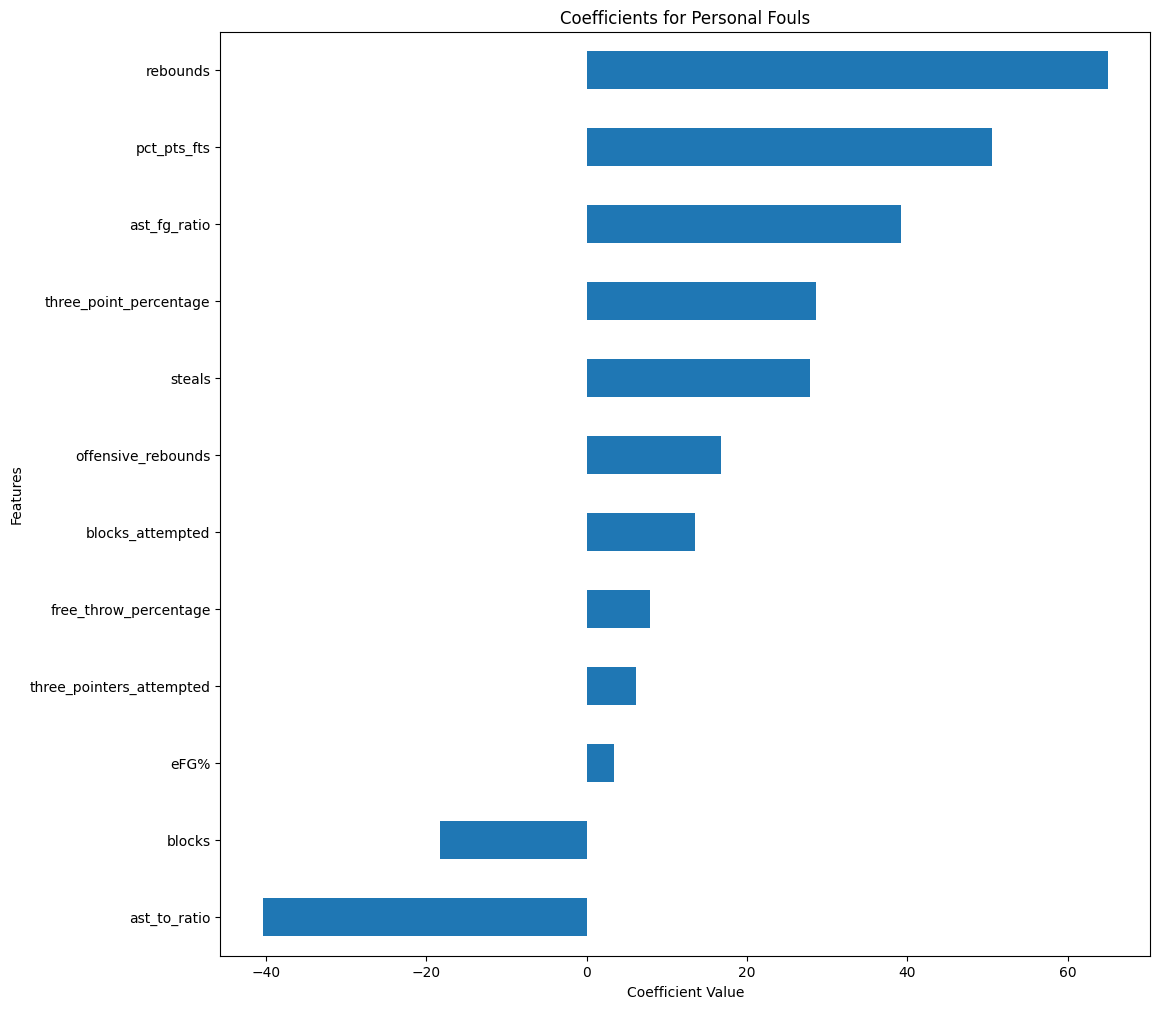

In [145]:
# Call the gen_coeff_barh function to display regression coefficients to the target feature
gen_coeff_barh(pf_era1_coefficients, 'Personal Fouls')

In [146]:
# Generate bootstrap coefficients 
bootstrap_results_pf_era1 = gen_bootstrap_coefficients(
    results_pf_era1['model'], results_pf_era1['X'], results_pf_era1['y'], results_pf_era1['feature_names']
)

Average Y: 1733.6516853932585
Average Training RMSE: 127.50656358455028, Average Testing RMSE: 133.58658633936983
Average Training R^2: 0.5115610701141453, Average Testing R^2: 0.4396890406689894
Sorted Coefficients: 
                               Mean     StdDev   CI Lower   CI Upper
rebounds                  70.432071  15.003442  42.025092  98.625346
pct_pts_fts               47.214962  10.216097  27.211349  67.966346
three_point_percentage    34.761274  12.967668   8.799409  59.216383
ast_fg_ratio              33.555642  11.052832  11.087041  55.842212
steals                    25.177573  10.763507   3.524973  44.621850
offensive_rebounds        15.634872  15.915191 -15.867200  47.863292
blocks_attempted          15.324704   9.904153  -4.279028  34.760190
three_pointers_attempted   8.057247  10.414208 -11.682435  29.099676
free_throw_percentage      2.969859   9.169720 -15.791589  20.475589
eFG%                      -2.808989  13.906304 -31.655444  24.716878
blocks                 

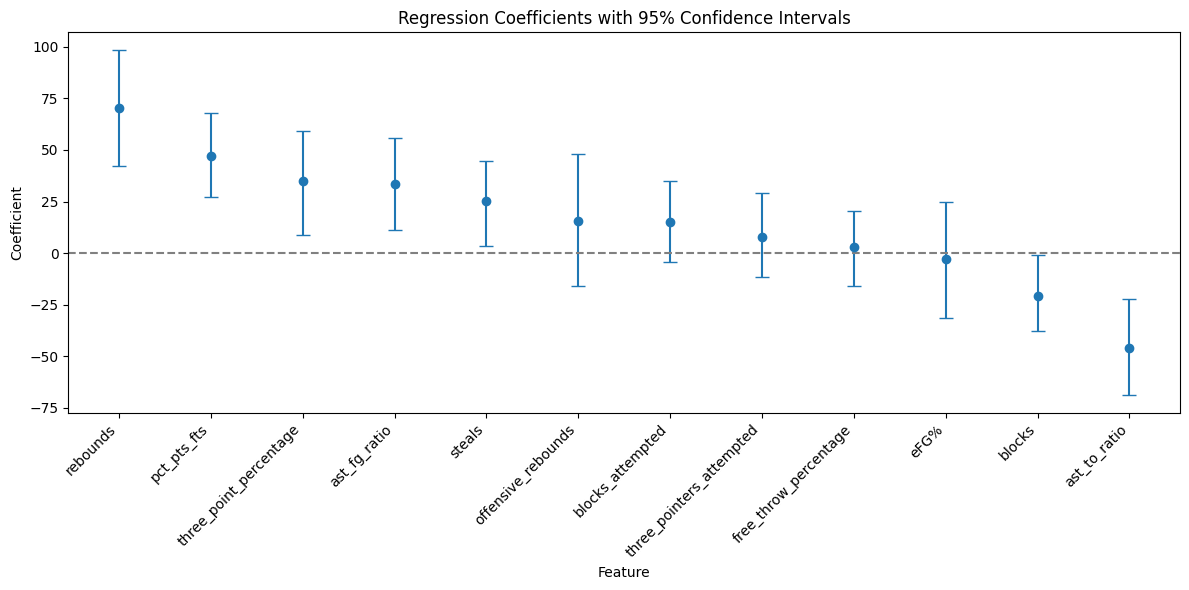

In [147]:
# Call the gen_ebar function to display regression coefficients with 95% confidence intervals
gen_ebar(bootstrap_results_pf_era1)

In [148]:
# Calculate and display the effects of the selected features on the target variable with the effect_on_target function
effect_on_target(bootstrap_results_pf_era1, pf_feats_era1, False)

A 67.434 unit increase in rebounds results in an approximate 21.455 change in the target variable.
A 0.004 unit increase in pct_pts_fts results in an approximate 10.302 change in the target variable.
A 0.007 unit increase in three_point_percentage results in an approximate 11.957 change in the target variable.
A 0.012 unit increase in ast_fg_ratio results in an approximate 9.624 change in the target variable.
A 12.111 unit increase in steals results in an approximate 4.040 change in the target variable.
A 7.932 unit increase in blocks results in an approximate -2.343 change in the target variable.
A 0.030 unit increase in ast_to_ratio results in an approximate -7.413 change in the target variable.
